In [1]:
import pandas as pd
import pyrenn as prn
import numpy as np
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from typing import Any, Dict, List
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
def df_extend(df: pd.DataFrame) -> pd.DataFrame:

    """This function creates new variables useful for the model these new variables are explained in the original paper.

    ### Args:
    - df: a `DataFrame`. Containing the data of the case study.

    ### Return:
    - a `DataFrame`. A new `DataFrame` containing new variables.
    """

    df_extended = df.copy()

    # creating new features
    df_extended["taper_ratio"] = df[["hw1","hw2"]].max(axis=1) / df[["hw1","hw2"]].min(axis=1)
    df_extended["flange_width_ratio"] = df.bf1 / df.bf2
    df_extended["height_to_width_ratio"] = df[["hw1","hw2"]].max(axis=1) / df[["bf1","bf2"]].max(axis=1)
    df_extended["beam_length"] = df.L / df[["hw1","hw2"]].max(axis=1)
    df_extended["plate_thickness_ratio_1"] = df.tf1 / df.tw
    df_extended["plate_thickness_ratio_2"] = df.tf2 / df.tw
    df_extended["flange_slenderness_1"] = df.bf1 / df.tf1
    df_extended["flange_slenderness_2"] = df.bf2 / df.tf2
    df_extended["web_slenderness"] = df[["hw1", "hw2"]].max(axis=1) / df.tw

    # change y and y_norm positions
    y_aux = df_extended.y
    y_norm_aux = df_extended.y_norm
    df_extended = df_extended.drop(columns=["y", "y_norm"])
    df_extended = df_extended
    df_extended["y"] = y_aux
    df_extended["y_norm"] = y_norm_aux

    return df_extended

In [3]:
def df_outlier_elimination(df: pd.DataFrame, target: str = 'norm') -> pd.DataFrame:
    
    """Eliminates the outliers from the normalized target value.
    
    ### Args:
    - df: a `DataFrame`. Containing the data of the case study.

    ### Return:
    - a `DataFrame`. A new `DataFrame` without the outliers from the normalized target value.
    """

    if target == "norm":
        y = df.copy().y_norm.values
    elif target == "original":
        y = df.copy().y.values
    else:
        print("error: type 'norm' or 'original', other input for <<target>> is not valid!")
    y_sort = np.sort(y)
    # quantiles
    Q1 = y_sort[round(len(y_sort)*0.25)]
    Q3 = y_sort[round(len(y_sort)*0.75)]
    # indices of outliers
    lower_indices = [i for i in range(len(y)) if y[i] < Q1-1.5*(Q3-Q1)]
    upper_indices = [i for i in range(len(y)) if y[i] > Q3+1.5*(Q3-Q1)]
    
    return df.copy().drop(index = lower_indices + upper_indices)

In [4]:
def l1_feature_score(X: Any, y: Any) -> Any:
    
    parameters: Dict[str, List] = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]}

    X = StandardScaler().fit_transform(X)
    clf = GridSearchCV(Lasso(), parameters)
    clf = clf.fit(X, y)
    alpha = clf.best_params_["alpha"]
    lasso = Lasso(alpha = alpha)
    lasso.fit(X, y)
    feature_score = lasso.coef_

    return feature_score

In [43]:
def modelAuto(df_train: pd.DataFrame
              , df_test: pd.DataFrame
              , PolyDegree: int
              , select_thresh: float = 0.0
              , alpha: float = 0.0001
              , hidden_layer_2: bool = False
              , neurons_1: int = 1
              , neurons_2: int = 1):

    t0 = time.time()
    # eliminating target outliers and creating compound features
    train = df_extend(df_train.copy())
    train = df_outlier_elimination(train, target='norm')

    # arrays for training
    X_train = train.iloc[:, :-2].values
    y_train = train.y_norm.values

    # L1 feature selection
    FeatureScore = l1_feature_score(X_train, y_train)
    FeatureScore = np.abs(FeatureScore) / np.sum(np.abs(FeatureScore)) # relative importance
    FeatureIndex = np.argwhere(FeatureScore >= select_thresh)
    FeatureIndex = FeatureIndex.reshape((1, len(FeatureIndex)))
    print("Selected features:")
    print(list(train.columns[FeatureIndex[0]]))
    X_train_filt = X_train[:, FeatureIndex[0]]
        
    # polynomial features
    poly = PolynomialFeatures(degree = PolyDegree).fit(X_train_filt)
    X_train_poly = poly.transform(X_train_filt)

    # normalization
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_poly)
    
    neural_net = [len(X_train_norm.T)]
    neural_net.append(neurons_1)
    if hidden_layer_2 == True: neural_net.append(neurons_2)
    neural_net.append(1)
    
    net = prn.CreateNN(neural_net)
    prn.train_LM(X_train_norm.T, y_train.T, net, verbose=True, k_max=500)

    test = df_extend(df_test.copy())

    # testing set transformations
    X_test = test.iloc[:, :-2].values
    y_test = test.y_norm.values
    X_test_filt = X_test[:, FeatureIndex[0]]
    X_test_poly = poly.transform(X_test_filt)
    X_test_norm = scaler.transform(X_test_poly)

    # predictions
    y_train_pred = prn.NNOut(X_train_norm.T, net)
    y_test_pred = prn.NNOut(X_test_norm.T, net)

    print("Time: ", time.time() - t0)
    # mean absolute error
    print("Training MAE:", mean_absolute_error(y_train, y_train_pred.T))
    print("Testing MAE:", mean_absolute_error(y_test, y_test_pred.T))
    print("Training MSE:", mean_squared_error(y_train, y_train_pred.T))
    print("Testing MSE:", mean_squared_error(y_test, y_test_pred.T))

    # coefficient of determination
    print("Training R^2:", r2_score(y_train, y_train_pred.T))
    print("Testing R^2:", r2_score(y_test, y_test_pred.T))

    plt.figure(figsize=(15,7))

    # Training results visualization
    plt.subplot(1, 2, 1)
    plt.scatter(MinMaxScaler().fit_transform(y_train.reshape(-1,1)), 
                MinMaxScaler().fit_transform(y_train_pred.T.reshape(-1,1)))
    plt.plot(range(2), range(2), color="black")
    plt.xlabel("y_true (normalized)", fontsize=12)
    plt.ylabel("y_pred (normalized)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Training data (poly="+str(PolyDegree)+"; thresh="+str(select_thresh)+")", fontsize=15)
    plt.grid()

    # Testing results visualization
    plt.subplot(1, 2, 2)
    plt.scatter(MinMaxScaler().fit_transform(y_test.reshape(-1,1)), 
                MinMaxScaler().fit_transform(y_test_pred.T.reshape(-1,1)), color="red")
    plt.plot(range(2), range(2), color="black")
    plt.xlabel("True (normalized)", fontsize=12)
    plt.ylabel("Prediction (normalized)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Testing data (poly="+str(PolyDegree)+"; thresh="+str(select_thresh)+")", fontsize=15)
    plt.grid()
    if hidden_layer_2 == True: plt.savefig(f'image_{str(neurons_1)}_{str(neurons_2)}.png')
    else: plt.savefig(f'image_{str(neurons_1)}.png')
    plt.show()

In [44]:
# train
df_train = pd.read_csv("training_set.csv", sep=';')
df_train_normalized = pd.read_csv("training_set_normalized.csv", sep = ";")
df_train["y_norm"] = df_train_normalized.y.copy()

# test
df_test = pd.read_csv("testing_set.csv", sep=";")
df_test_normalized = pd.read_csv("testing_set_normalized.csv", sep=";")
df_test["y_norm"] = df_test_normalized.y.copy()

# lasso relative score for feature selection
thresholds = [0.0000, 0.0005, 0.0012, 0.0080, 0.0161, 0.0166, 0.0186, 0.0290, 0.0300, 0.0450]

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Iteration:  0 		Error:  12314.71026694486 	scale factor:  3.0
Iteration:  1 		Error:  4670.092614034789 	scale factor:  0.3
Iteration:  2 		Error:  3972.441518531482 	scale factor:  0.3
Iteration:  3 		Error:  1959.5775512954633 	scale factor:  0.3
Iteration:  4 		Error:  1925.7102029650398 	scale factor:  0.3
Iteration:  5 		Error:  1749.535472594768 	scale factor:  0.03
Iteration:  6 		Error:  1318.2035323329424 	scale factor:  0.3
Iteration:  7 		Error:  340.86345424534625 	scale factor:  0.3
Iteration:  8 		Error:  259.49985896730163 	scale factor:  0.3
Iteration:  9 		Error:  209.6465670681465 	scale factor:  0.3
Iteration:  10 		Error:  145.12154437434796 	scale fac

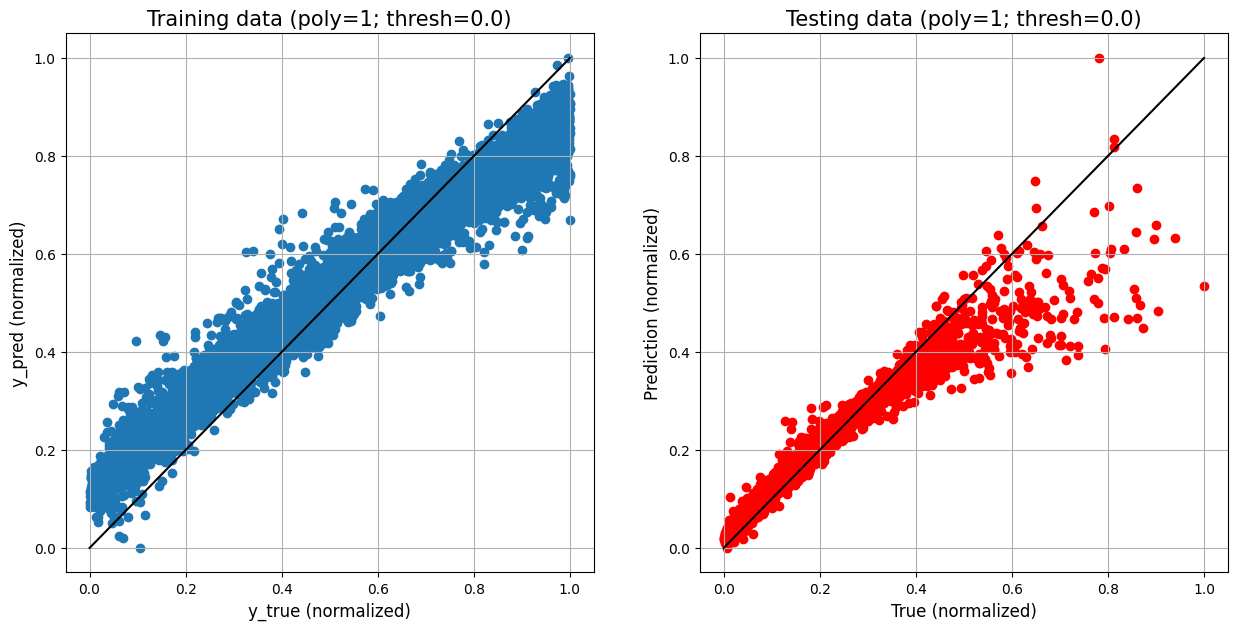


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  8251.133824438788 	scale factor:  3.0
Iteration:  1 		Error:  1611.4390571699105 	scale factor:  3.0
Iteration:  2 		Error:  760.3630281083726 	scale factor:  3.0
Iteration:  3 		Error:  637.7377222053567 	scale factor:  30.0
Iteration:  4 		Error:  583.9284471966521 	scale factor:  30.0
Iteration:  5 		Error:  540.4927322256756 	scale factor:  30.0
Iteration:  6 		Error:  479.4724324056623 	scale factor:  3.0
Iteration:  7 		Error:  391.89982281430173 	scale factor:  3.0
Iteration:  8 		Error:  326.0944583945882 	scale factor:  3.0
Iteration:  9 		Error:  288.2593273911833 	scale factor:  3.0
Iteration:  10 		Error:  234.80813955760567 	scale factor:  3.0
Iteration:  11 		Error:  205.4552742857071 	scale factor:  3.0
It

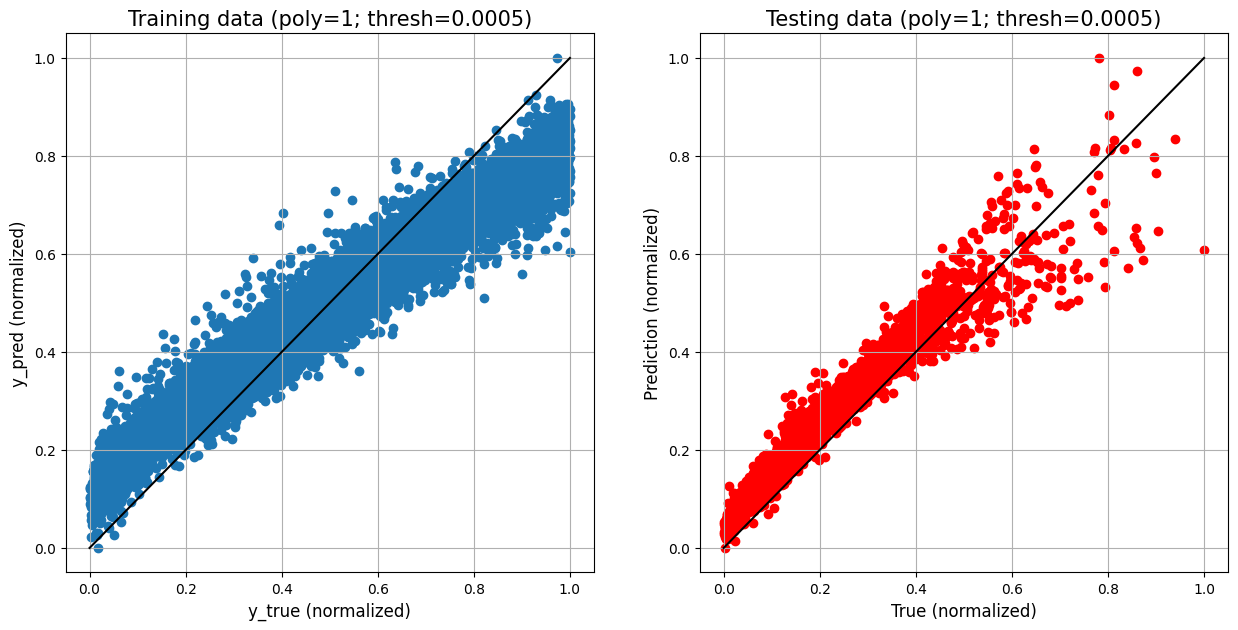


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  27681.516387027536 	scale factor:  3.0
Iteration:  1 		Error:  8000.384124592412 	scale factor:  0.3
Iteration:  2 		Error:  7102.710675764713 	scale factor:  0.3
Iteration:  3 		Error:  2275.68214184317 	scale factor:  0.3
Iteration:  4 		Error:  764.8280964921987 	scale factor:  3.0
Iteration:  5 		Error:  558.4553132024944 	scale factor:  3.0
Iteration:  6 		Error:  514.2758586671903 	scale factor:  3.0
Iteration:  7 		Error:  500.6928430087823 	scale factor:  3.0
Iteration:  8 		Error:  490.30849747696936 	scale factor:  3.0
Iteration:  9 		Error:  480.3409273575005 	scale factor:  3.0
Iteration:  10 		Error:  470.43307962778795 	scale factor:  3.0
Iteration:  11 		Error:  461.4275049609996 	scale factor:  3.0
Iteration:  1

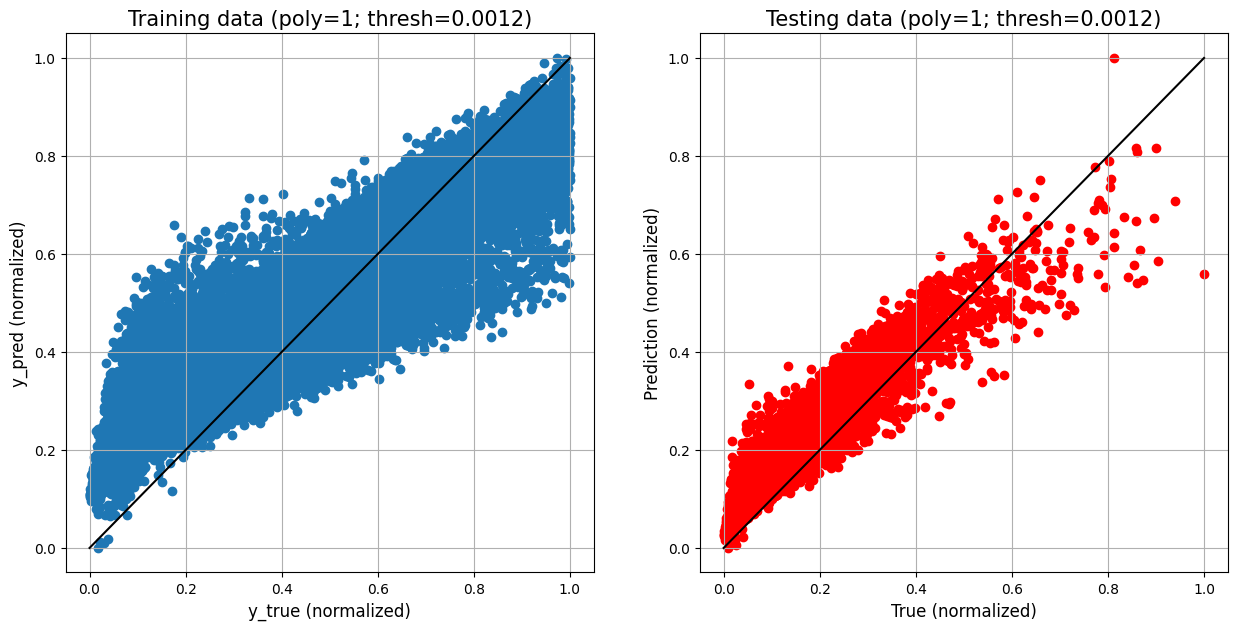


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  6652.530722597248 	scale factor:  3.0
Iteration:  1 		Error:  1270.9466480137116 	scale factor:  3.0
Iteration:  2 		Error:  734.8147883182544 	scale factor:  30.0
Iteration:  3 		Error:  677.4418948802055 	scale factor:  3.0
Iteration:  4 		Error:  560.4079935035248 	scale factor:  3.0
Iteration:  5 		Error:  524.4671715975146 	scale factor:  3.0
Iteration:  6 		Error:  505.9066337927577 	scale factor:  3.0
Iteration:  7 		Error:  488.1062254227836 	scale factor:  3.0
Iteration:  8 		Error:  471.32901877518805 	scale factor:  3.0
Iteration:  9 		Error:  456.44305666392586 	scale factor:  3.0
Iteration:  10 		Error:  443.8533845958155 	scale factor:  3.0
Iteration:  11 		Error:  433.77947115808456 	scale factor:  3.0
Iteration:  12 		E

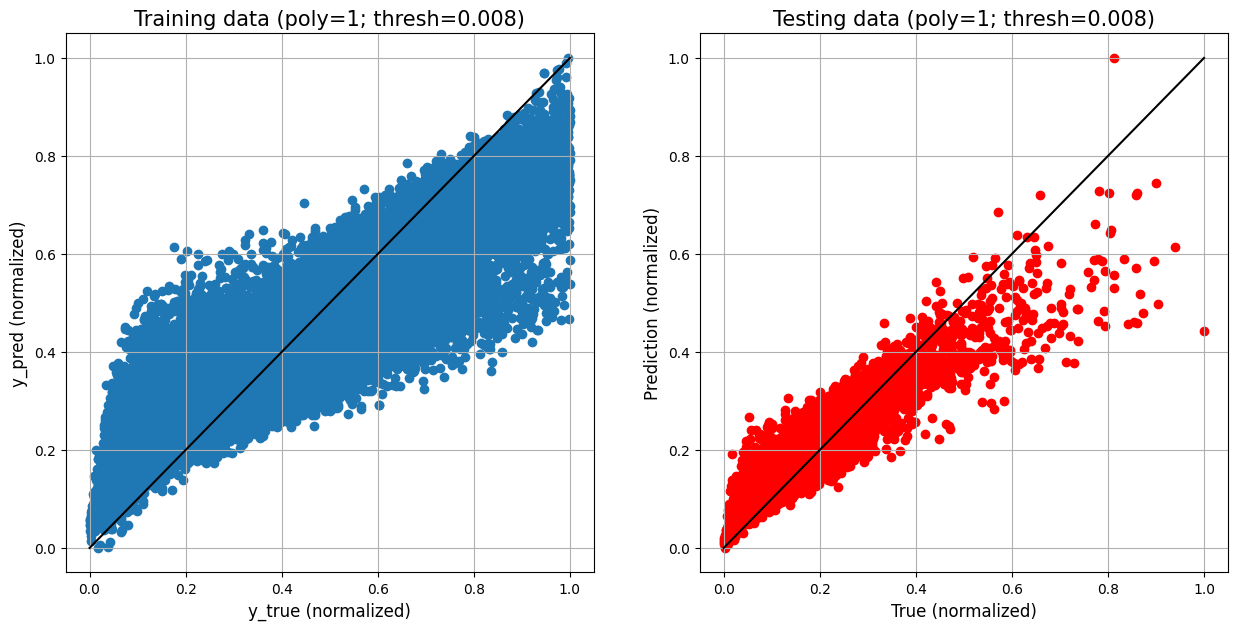


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  11484.713844106987 	scale factor:  3.0
Iteration:  1 		Error:  5708.867020481226 	scale factor:  3.0
Iteration:  2 		Error:  1855.6358084384588 	scale factor:  3.0
Iteration:  3 		Error:  687.2287157356893 	scale factor:  3.0
Iteration:  4 		Error:  583.4298018365804 	scale factor:  3.0
Iteration:  5 		Error:  559.5694801826253 	scale factor:  3.0
Iteration:  6 		Error:  545.2922818378372 	scale factor:  3.0
Iteration:  7 		Error:  532.0603453977567 	scale factor:  3.0
Iteration:  8 		Error:  521.7107632727498 	scale factor:  3.0
Iteration:  9 		Error:  513.5975268392909 	scale factor:  3.0
Iteration:  10 		Error:  506.3685617672978 	scale factor:  3.0
Iteration:  11 		Error:  499.44088999741814 	scale factor:  3.0
Iteration:  12 		Error:  4

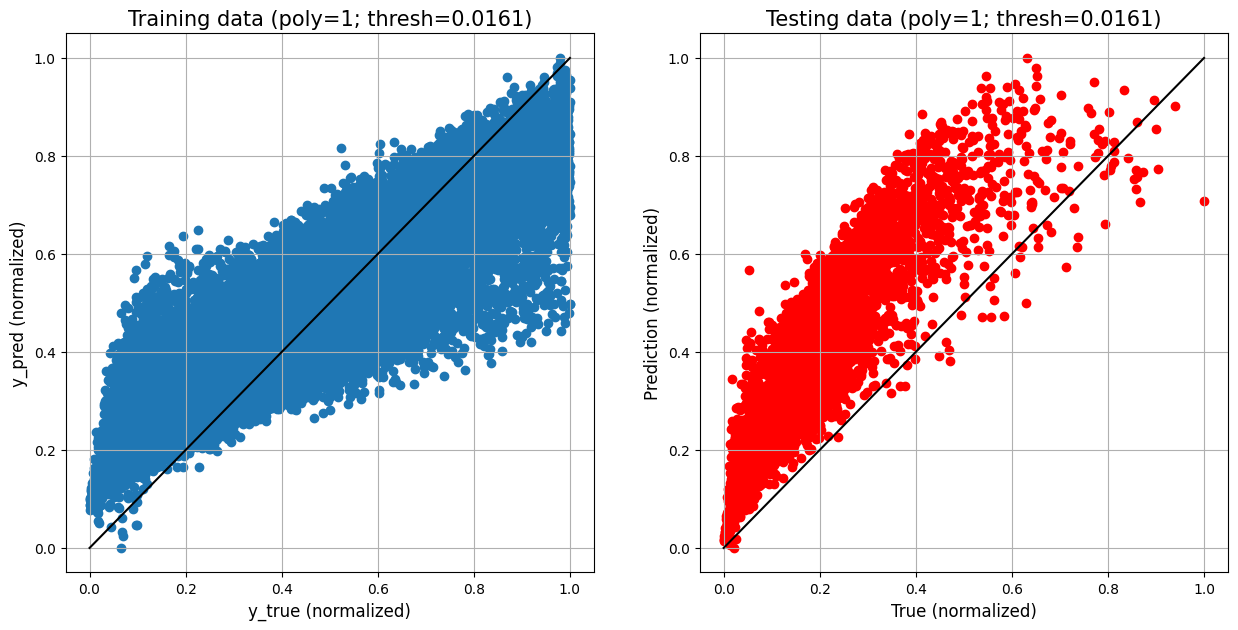


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Iteration:  0 		Error:  34024.11607995411 	scale factor:  3.0
Iteration:  1 		Error:  8583.861615658414 	scale factor:  0.3
Iteration:  2 		Error:  3567.9182619796843 	scale factor:  3.0
Iteration:  3 		Error:  2522.8887366355657 	scale factor:  0.3
Iteration:  4 		Error:  1481.5883658809894 	scale factor:  3.0
Iteration:  5 		Error:  1136.9052644962094 	scale factor:  0.3
Iteration:  6 		Error:  689.3658438845007 	scale factor:  3.0
Iteration:  7 		Error:  613.3072750391291 	scale factor:  0.3
Iteration:  8 		Error:  489.88310820375347 	scale factor:  3.0
Iteration:  9 		Error:  468.6237787302042 	scale factor:  3.0
Iteration:  10 		Error:  462.8510298433041 	scale factor:  3.0
Iteration:  11 		Error:  459.0351646959982 	scale factor:  3.0
Iteration:  12 		Error:  455.9725208999171 	scale f

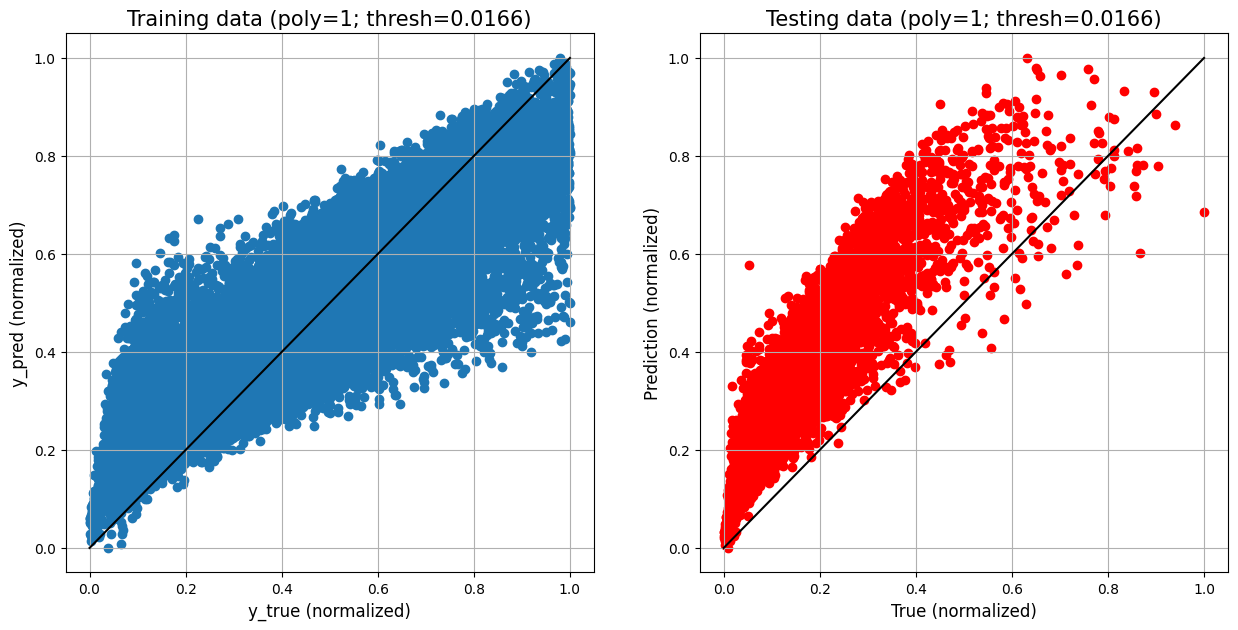


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  35834.98624554514 	scale factor:  3.0
Iteration:  1 		Error:  23623.67054322965 	scale factor:  0.3
Iteration:  2 		Error:  4003.499023559123 	scale factor:  0.3
Iteration:  3 		Error:  2706.1216378345034 	scale factor:  3.0
Iteration:  4 		Error:  1116.4670866200759 	scale factor:  0.3
Iteration:  5 		Error:  664.2946910722178 	scale factor:  3.0
Iteration:  6 		Error:  536.3929704432262 	scale factor:  3.0
Iteration:  7 		Error:  523.6444617373718 	scale factor:  3.0
Iteration:  8 		Error:  514.078120839298 	scale factor:  3.0
Iteration:  9 		Error:  507.37313272412035 	scale factor:  3.0
Iteration:  10 		Error:  502.47643384471155 	scale factor:  3.0
Iteration:  11 		Error:  498.68159401260124 	scale factor:  3.0
Iteration:  12 		Error:  495.52819684976424 	scale factor:  3.0
Iteration:  

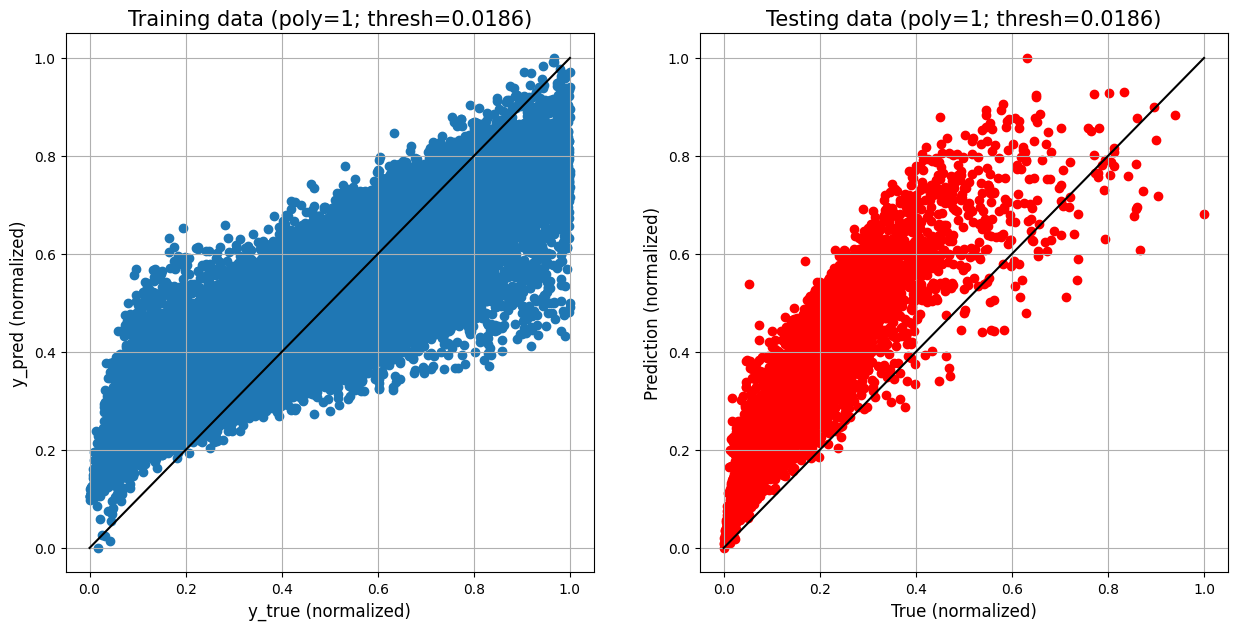


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  48825.47997088219 	scale factor:  3.0
Iteration:  1 		Error:  7437.520424149473 	scale factor:  3.0
Iteration:  2 		Error:  2168.2741673184632 	scale factor:  3.0
Iteration:  3 		Error:  2163.712815675759 	scale factor:  0.3
Iteration:  4 		Error:  2109.735897645925 	scale factor:  0.3
Iteration:  5 		Error:  1516.7770567245482 	scale factor:  0.3
Iteration:  6 		Error:  805.0792150413788 	scale factor:  0.3
Iteration:  7 		Error:  718.5380179732756 	scale factor:  0.03
Iteration:  8 		Error:  577.1196034875065 	scale factor:  0.3
Iteration:  9 		Error:  463.3774695346526 	scale factor:  3.0
Iteration:  10 		Error:  459.8819714983602 	scale factor:  3.0
Iteration:  11 		Error:  458.4580657804596 	scale factor:  3.0
Iteration:  12 		Error:  457.3675183385709 	scale factor:  3.0
Iteration:  13 		Error:  456.4

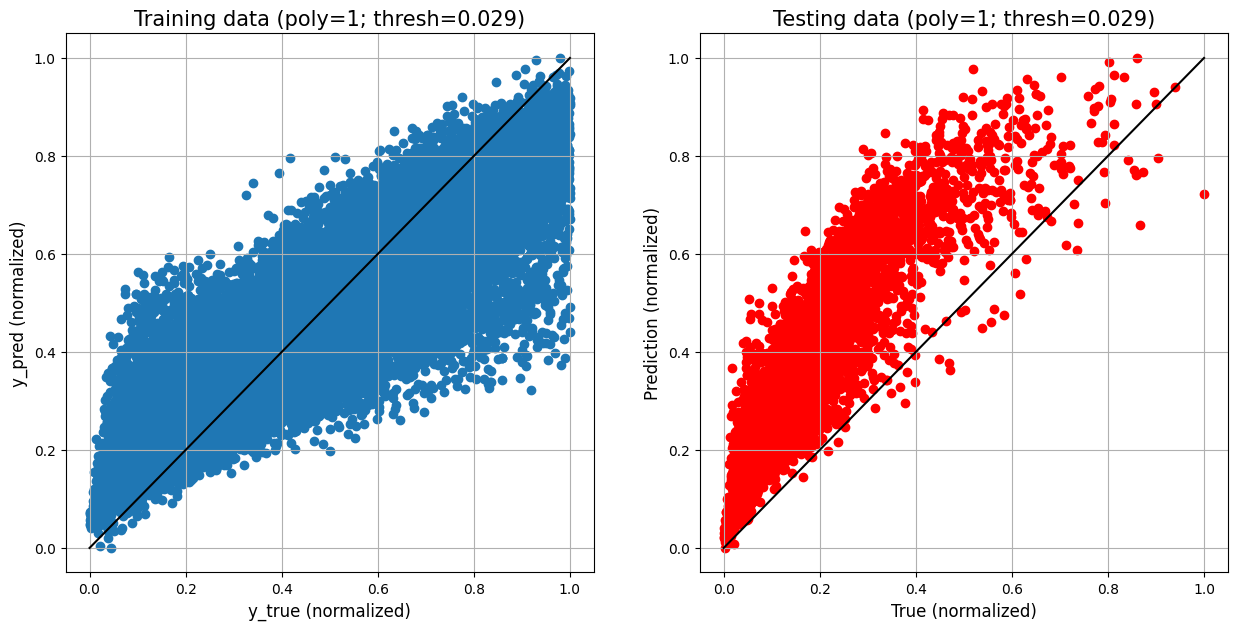


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  19619.264472590672 	scale factor:  3.0
Iteration:  1 		Error:  2774.4501508064145 	scale factor:  3.0
Iteration:  2 		Error:  1016.7221379759837 	scale factor:  3.0
Iteration:  3 		Error:  837.0147336032328 	scale factor:  3.0
Iteration:  4 		Error:  695.3832193371424 	scale factor:  3.0
Iteration:  5 		Error:  619.6838197464285 	scale factor:  3.0
Iteration:  6 		Error:  563.7986196075645 	scale factor:  3.0
Iteration:  7 		Error:  539.3228725957969 	scale factor:  3.0
Iteration:  8 		Error:  522.5118184645046 	scale factor:  3.0
Iteration:  9 		Error:  510.2176772350533 	scale factor:  3.0
Iteration:  10 		Error:  499.9775008684726 	scale factor:  3.0
Iteration:  11 		Error:  492.4483416602287 	scale factor:  3.0
Iteration:  12 		Error:  487.0144871144502 	scale factor:  3.0
Iteration:  13 		Error:  482.8364070

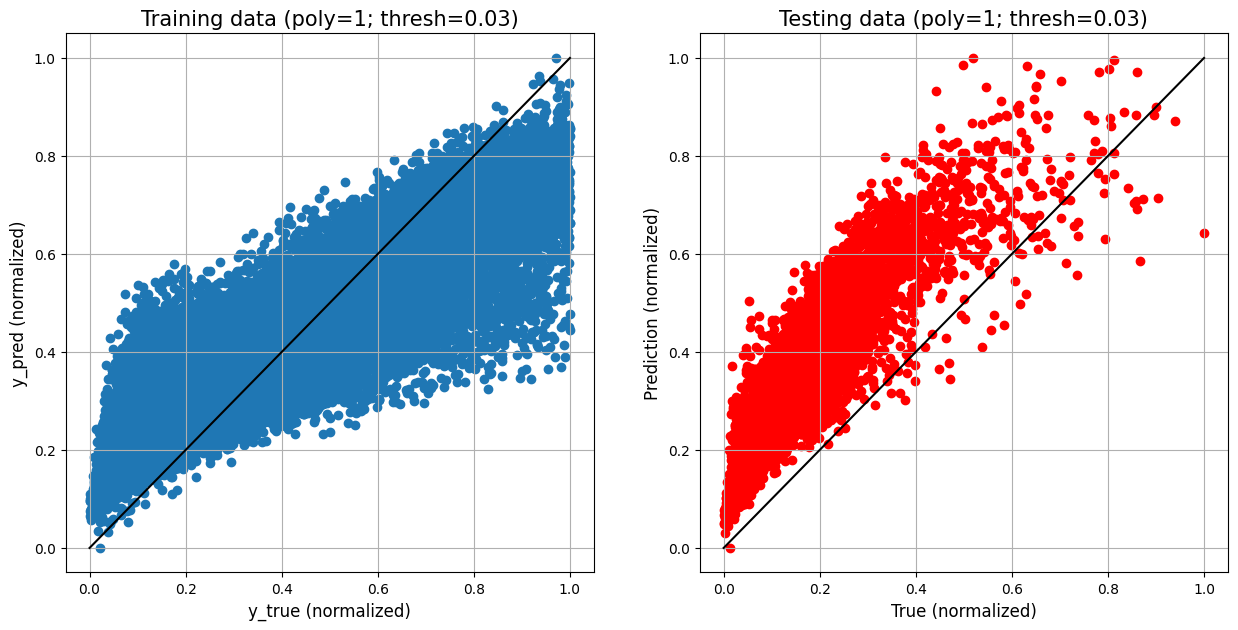


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  6181.33555259244 	scale factor:  3.0
Iteration:  1 		Error:  3916.971532977408 	scale factor:  0.3
Iteration:  2 		Error:  972.2581132187411 	scale factor:  3.0
Iteration:  3 		Error:  708.1664428318812 	scale factor:  3.0
Iteration:  4 		Error:  613.5247520673121 	scale factor:  3.0
Iteration:  5 		Error:  592.8101736844984 	scale factor:  3.0
Iteration:  6 		Error:  586.0202637545854 	scale factor:  3.0
Iteration:  7 		Error:  581.27405093027 	scale factor:  3.0
Iteration:  8 		Error:  577.1698066252499 	scale factor:  3.0
Iteration:  9 		Error:  572.9016520677419 	scale factor:  3.0
Iteration:  10 		Error:  568.2390218857174 	scale factor:  3.0
Iteration:  11 		Error:  563.1611558244894 	scale factor:  3.0
Iteration:  12 		Error:  557.7720629575664 	scale factor:  3.0
Iteration:  13 		Error:  552.3272304761721 	sca

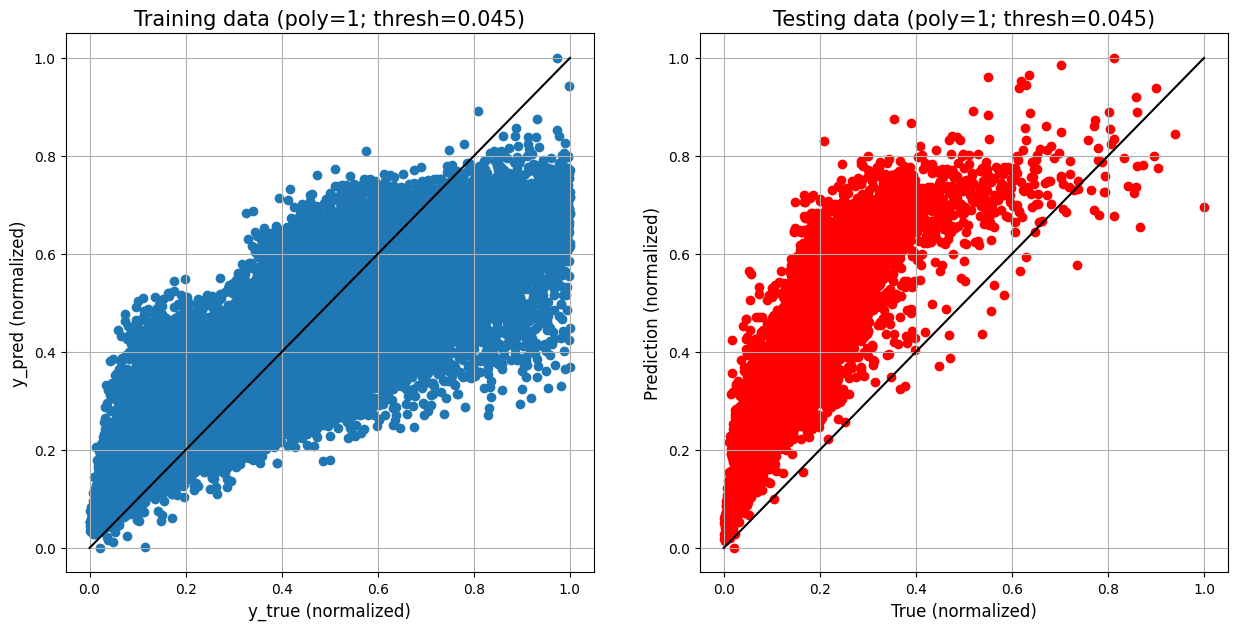


-----------------------


In [46]:
for thr in thresholds:
    
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 1, select_thresh = thr, neurons_1=18)
    print("")
    print("-----------------------")

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Iteration:  0 		Error:  25040.054013533998 	scale factor:  3.0
Iteration:  1 		Error:  4814.563104474946 	scale factor:  3.0
Iteration:  2 		Error:  3547.5096021831114 	scale factor:  0.3
Iteration:  3 		Error:  1213.8027168366984 	scale factor:  0.3
Iteration:  4 		Error:  837.127690071686 	scale factor:  0.3
Iteration:  5 		Error:  261.86031132687793 	scale factor:  0.3
Iteration:  6 		Error:  124.5194052966586 	scale factor:  0.3
Iteration:  7 		Error:  95.04218402084359 	scale factor:  0.3
Iteration:  8 		Error:  84.09488640513746 	scale factor:  0.3
Iteration:  9 		Error:  64.65174342033511 	scale factor:  0.3
Iteration:  10 		Error:  59.24694629815225 	scale factor:

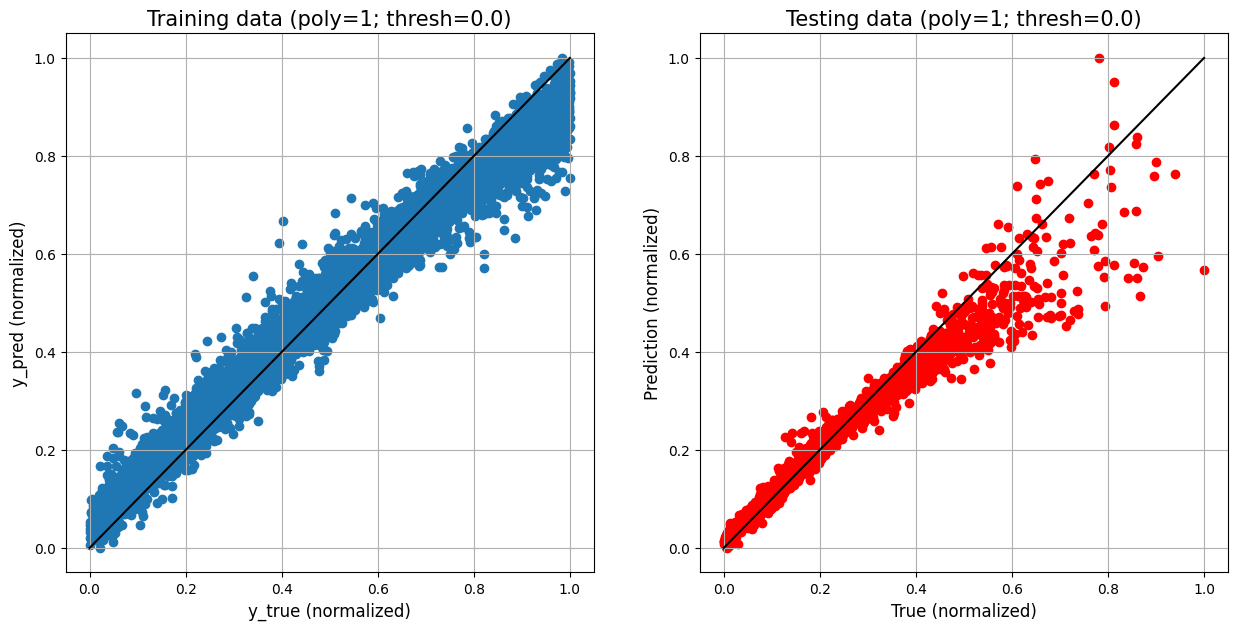


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  77247.72848628863 	scale factor:  3.0
Iteration:  1 		Error:  12381.693371481571 	scale factor:  0.3
Iteration:  2 		Error:  8483.661480994091 	scale factor:  0.3
Iteration:  3 		Error:  1117.7593281518523 	scale factor:  0.3
Iteration:  4 		Error:  366.6898576568591 	scale factor:  3.0
Iteration:  5 		Error:  190.47270416981053 	scale factor:  3.0
Iteration:  6 		Error:  166.39686275195652 	scale factor:  3.0
Iteration:  7 		Error:  155.4852457822985 	scale factor:  3.0
Iteration:  8 		Error:  147.06438767290933 	scale factor:  3.0
Iteration:  9 		Error:  140.5984790683147 	scale factor:  3.0
Iteration:  10 		Error:  135.5642731494146 	scale factor:  3.0
Iteration:  11 		Error:  131.51334534986069 	scale factor:  3.0
It

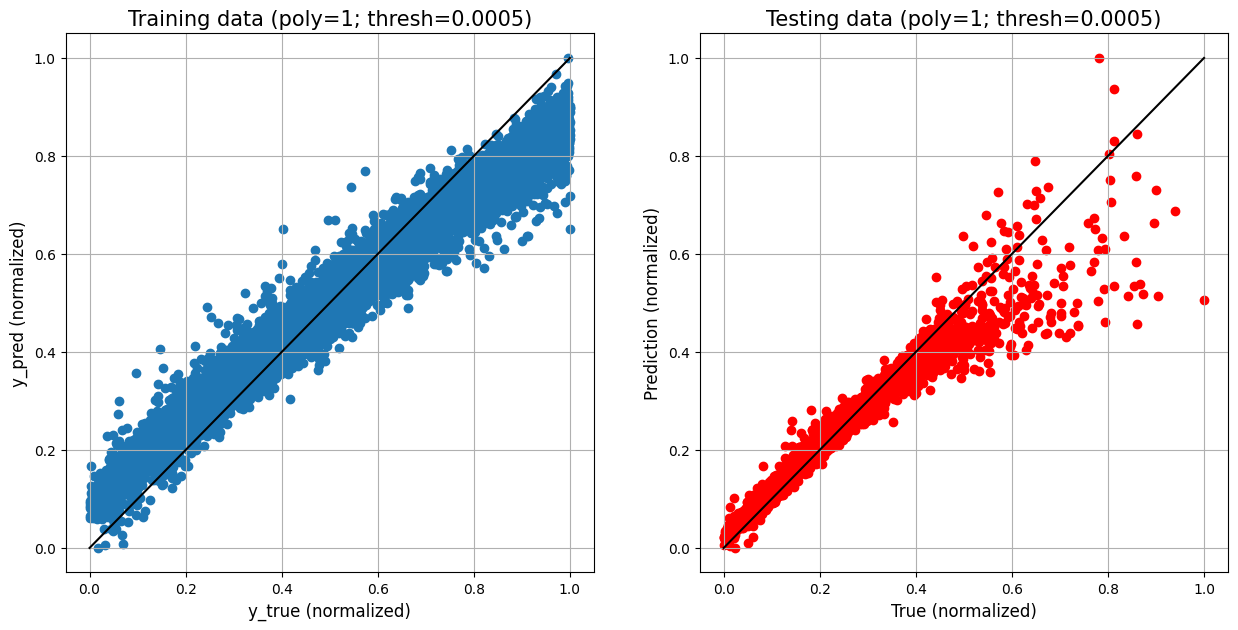


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  14302.12420488207 	scale factor:  3.0
Iteration:  1 		Error:  8585.455471054376 	scale factor:  0.3
Iteration:  2 		Error:  3938.8292019878154 	scale factor:  0.3
Iteration:  3 		Error:  1863.5734470576333 	scale factor:  0.3
Iteration:  4 		Error:  794.1892198687308 	scale factor:  0.3
Iteration:  5 		Error:  724.0824347152063 	scale factor:  0.3
Iteration:  6 		Error:  610.8122589770658 	scale factor:  0.3
Iteration:  7 		Error:  378.9233101030502 	scale factor:  0.3
Iteration:  8 		Error:  362.41682541604746 	scale factor:  0.3
Iteration:  9 		Error:  358.3970271927815 	scale factor:  0.3
Iteration:  10 		Error:  354.0482763081235 	scale factor:  0.3
Iteration:  11 		Error:  351.5688335550475 	scale factor:  0.3
Iteration:  

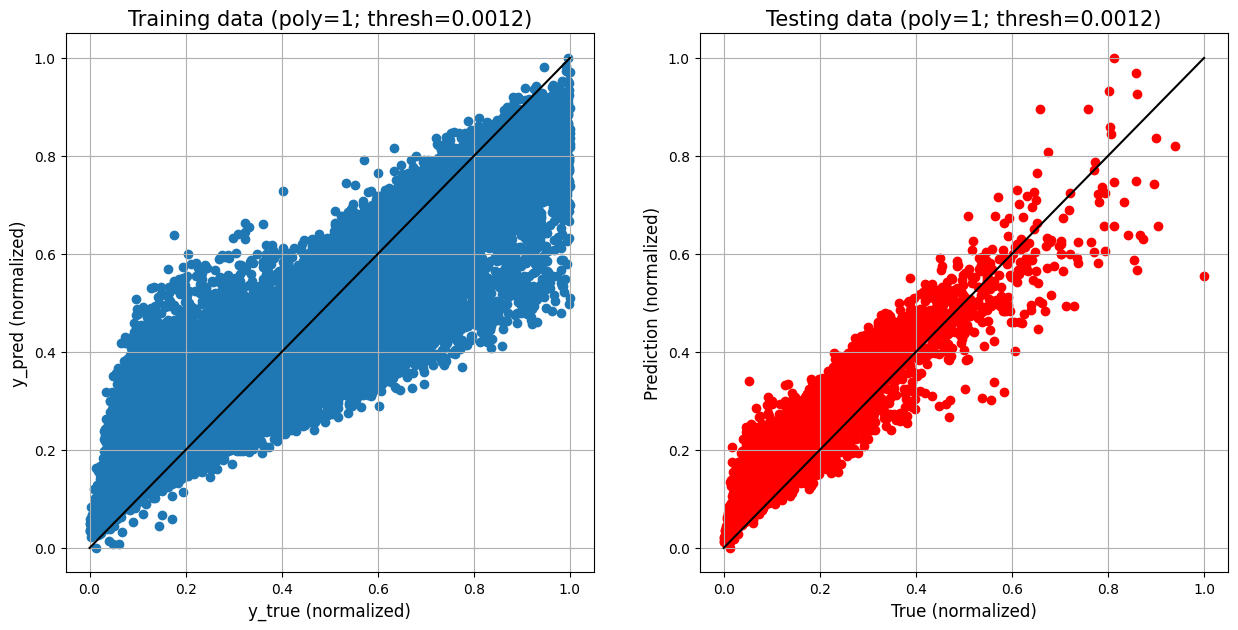


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  18085.106903983622 	scale factor:  3.0
Iteration:  1 		Error:  16759.93187735834 	scale factor:  0.3
Iteration:  2 		Error:  2363.954386868042 	scale factor:  0.3
Iteration:  3 		Error:  642.1745419169263 	scale factor:  3.0
Iteration:  4 		Error:  528.0661668988641 	scale factor:  3.0
Iteration:  5 		Error:  497.28871918164316 	scale factor:  3.0
Iteration:  6 		Error:  472.4303445218841 	scale factor:  3.0
Iteration:  7 		Error:  453.0853456059257 	scale factor:  3.0
Iteration:  8 		Error:  437.95994968478703 	scale factor:  3.0
Iteration:  9 		Error:  426.4487822072046 	scale factor:  3.0
Iteration:  10 		Error:  417.2966682355303 	scale factor:  3.0
Iteration:  11 		Error:  409.62794842461983 	scale factor:  3.0
Iteration:  12 		Er

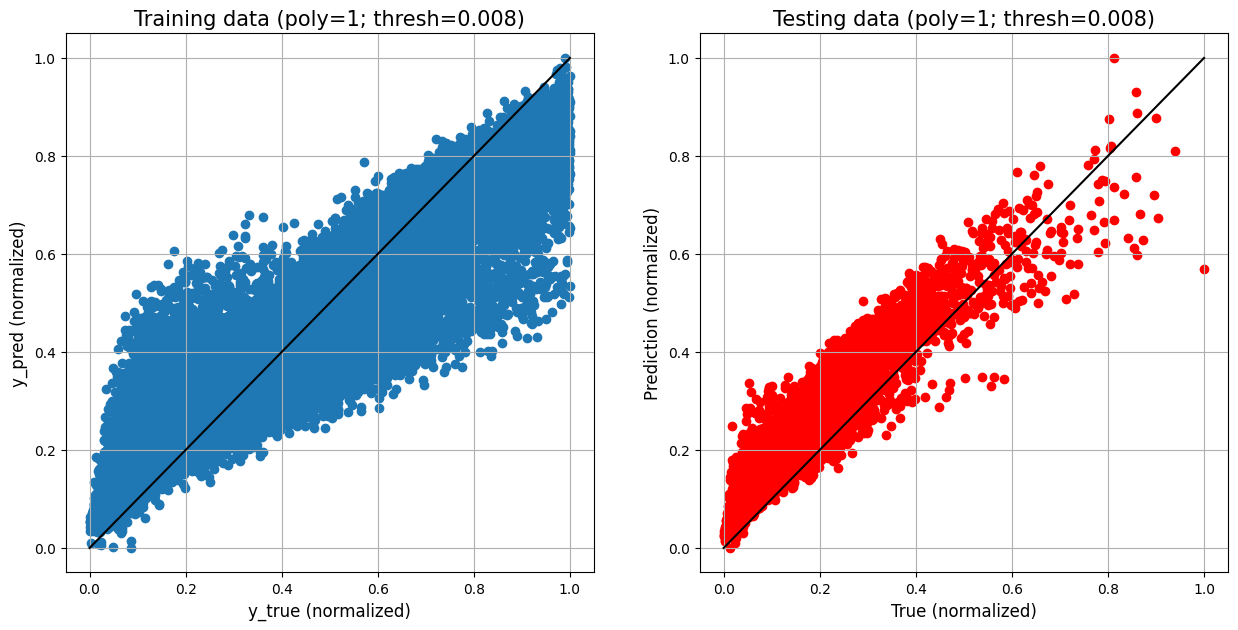


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  47835.43592186192 	scale factor:  3.0
Iteration:  1 		Error:  19208.047874993612 	scale factor:  0.3
Iteration:  2 		Error:  19011.21129782343 	scale factor:  0.03
Iteration:  3 		Error:  6017.850009644047 	scale factor:  0.03
Iteration:  4 		Error:  4733.054004078716 	scale factor:  0.03
Iteration:  5 		Error:  2698.8193503049324 	scale factor:  0.03
Iteration:  6 		Error:  1065.3711678147756 	scale factor:  0.03
Iteration:  7 		Error:  496.97502574452864 	scale factor:  0.3
Iteration:  8 		Error:  467.3249782312166 	scale factor:  0.3
Iteration:  9 		Error:  428.76544978008405 	scale factor:  0.3
Iteration:  10 		Error:  424.55450558160095 	scale factor:  0.3
Iteration:  11 		Error:  419.50338185568546 	scale factor:  0.3
Iteration:  12 		

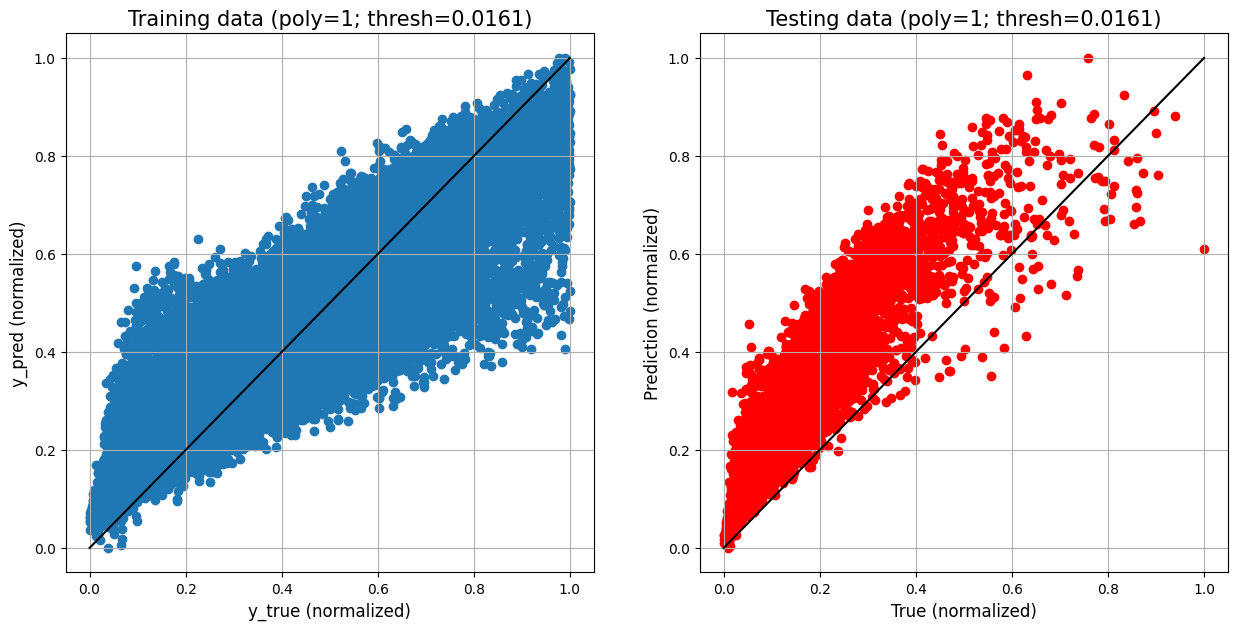


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Iteration:  0 		Error:  50064.984136099774 	scale factor:  3.0
Iteration:  1 		Error:  9221.38557875248 	scale factor:  0.3
Iteration:  2 		Error:  1753.1906905939063 	scale factor:  3.0
Iteration:  3 		Error:  807.536837172895 	scale factor:  3.0
Iteration:  4 		Error:  558.3849623702349 	scale factor:  3.0
Iteration:  5 		Error:  523.5266629917608 	scale factor:  3.0
Iteration:  6 		Error:  501.78817511691096 	scale factor:  3.0
Iteration:  7 		Error:  483.80353948089333 	scale factor:  3.0
Iteration:  8 		Error:  468.6696150131428 	scale factor:  3.0
Iteration:  9 		Error:  457.70683934808375 	scale factor:  3.0
Iteration:  10 		Error:  450.14498318370534 	scale factor:  3.0
Iteration:  11 		Error:  444.8540482089383 	scale factor:  3.0
Iteration:  12 		Error:  440.9818650876358 	scale fa

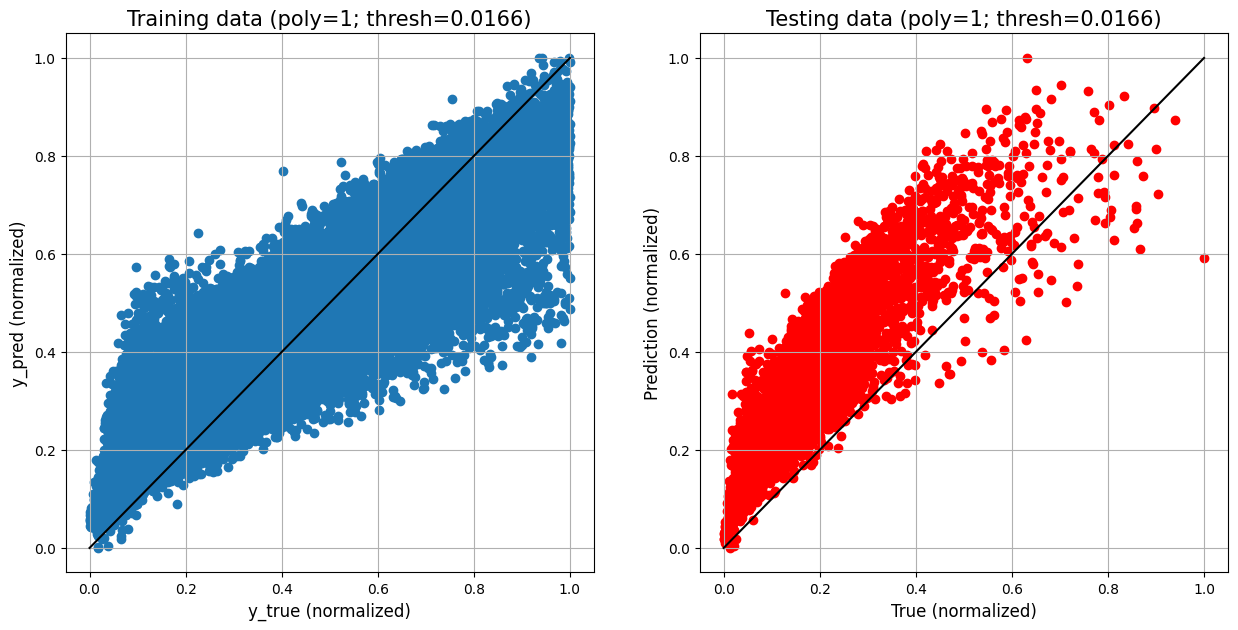


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  10411.864880659792 	scale factor:  3.0
Iteration:  1 		Error:  1309.8871571964655 	scale factor:  3.0
Iteration:  2 		Error:  925.7653674555618 	scale factor:  3.0
Iteration:  3 		Error:  647.0921531630263 	scale factor:  3.0
Iteration:  4 		Error:  549.3197370265004 	scale factor:  3.0
Iteration:  5 		Error:  522.1252900571658 	scale factor:  3.0
Iteration:  6 		Error:  503.11531558052474 	scale factor:  3.0
Iteration:  7 		Error:  489.12192665619574 	scale factor:  3.0
Iteration:  8 		Error:  478.0929123030853 	scale factor:  3.0
Iteration:  9 		Error:  468.6605213338532 	scale factor:  3.0
Iteration:  10 		Error:  460.59615268820346 	scale factor:  3.0
Iteration:  11 		Error:  454.2888021407431 	scale factor:  3.0
Iteration:  12 		Error:  449.7637880851886 	scale factor:  3.0
Iteration:  

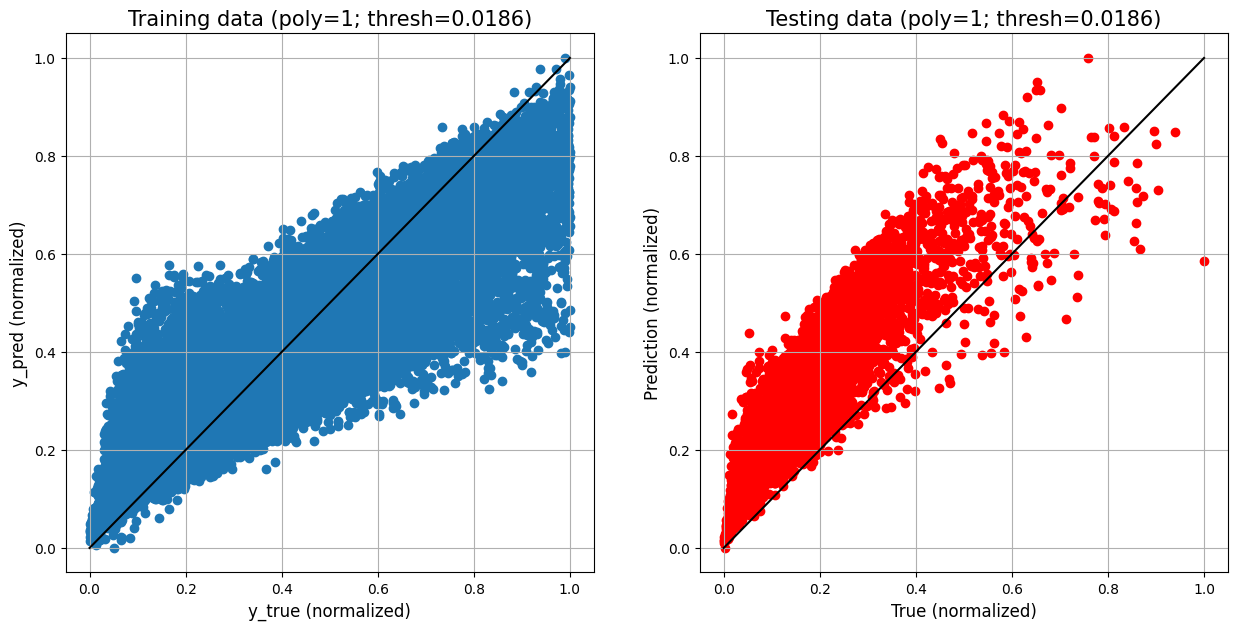


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  54732.16308944986 	scale factor:  3.0
Iteration:  1 		Error:  10929.344204605795 	scale factor:  0.3
Iteration:  2 		Error:  2839.651989827481 	scale factor:  0.3
Iteration:  3 		Error:  1256.0032218652427 	scale factor:  0.3
Iteration:  4 		Error:  674.4636793485079 	scale factor:  3.0
Iteration:  5 		Error:  521.5867742065211 	scale factor:  3.0
Iteration:  6 		Error:  505.01639917966065 	scale factor:  3.0
Iteration:  7 		Error:  494.9632009514805 	scale factor:  3.0
Iteration:  8 		Error:  487.51928824346703 	scale factor:  3.0
Iteration:  9 		Error:  481.89313728553276 	scale factor:  3.0
Iteration:  10 		Error:  477.56228665693396 	scale factor:  3.0
Iteration:  11 		Error:  474.2512211711138 	scale factor:  3.0
Iteration:  12 		Error:  471.74051518397863 	scale factor:  3.0
Iteration:  13 		Error:  4

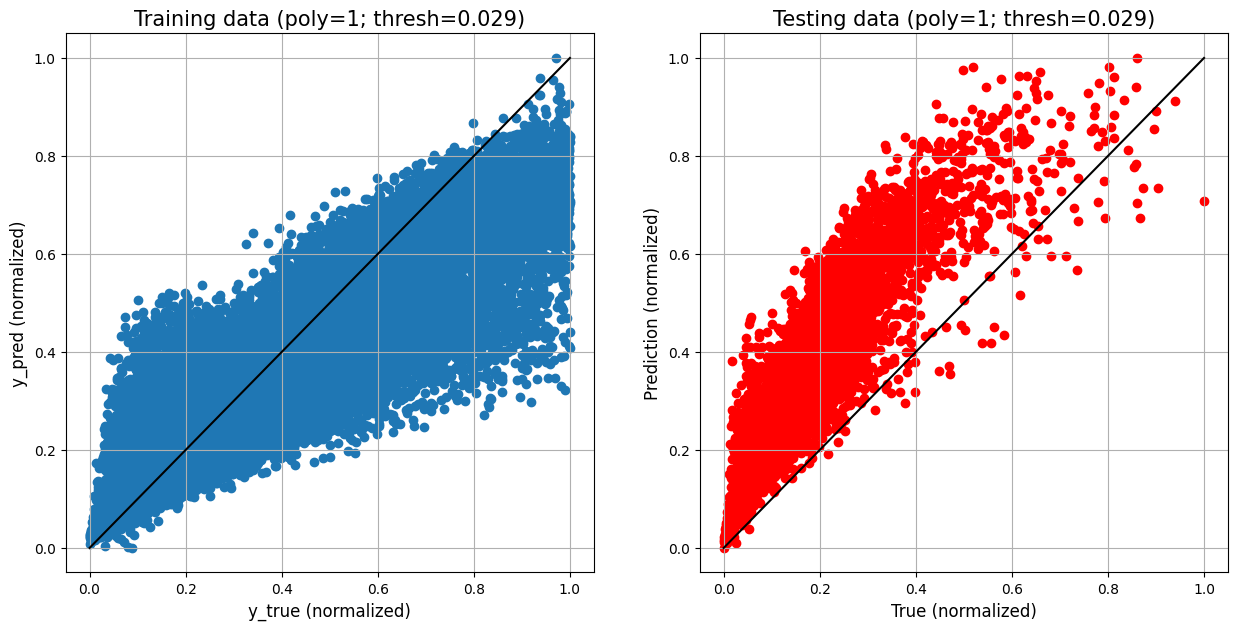


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  65526.79405226554 	scale factor:  3.0
Iteration:  1 		Error:  6024.677133564322 	scale factor:  0.3
Iteration:  2 		Error:  1043.1659929420348 	scale factor:  3.0
Iteration:  3 		Error:  564.0589334782388 	scale factor:  3.0
Iteration:  4 		Error:  532.1820529274432 	scale factor:  3.0
Iteration:  5 		Error:  515.1155108090999 	scale factor:  3.0
Iteration:  6 		Error:  506.0973845581317 	scale factor:  3.0
Iteration:  7 		Error:  499.7600753021247 	scale factor:  3.0
Iteration:  8 		Error:  494.7406537906261 	scale factor:  3.0
Iteration:  9 		Error:  490.3900042901395 	scale factor:  3.0
Iteration:  10 		Error:  486.4889751301845 	scale factor:  3.0
Iteration:  11 		Error:  482.9835025588013 	scale factor:  3.0
Iteration:  12 		Error:  479.878430628566 	scale factor:  3.0
Iteration:  13 		Error:  477.1754893628

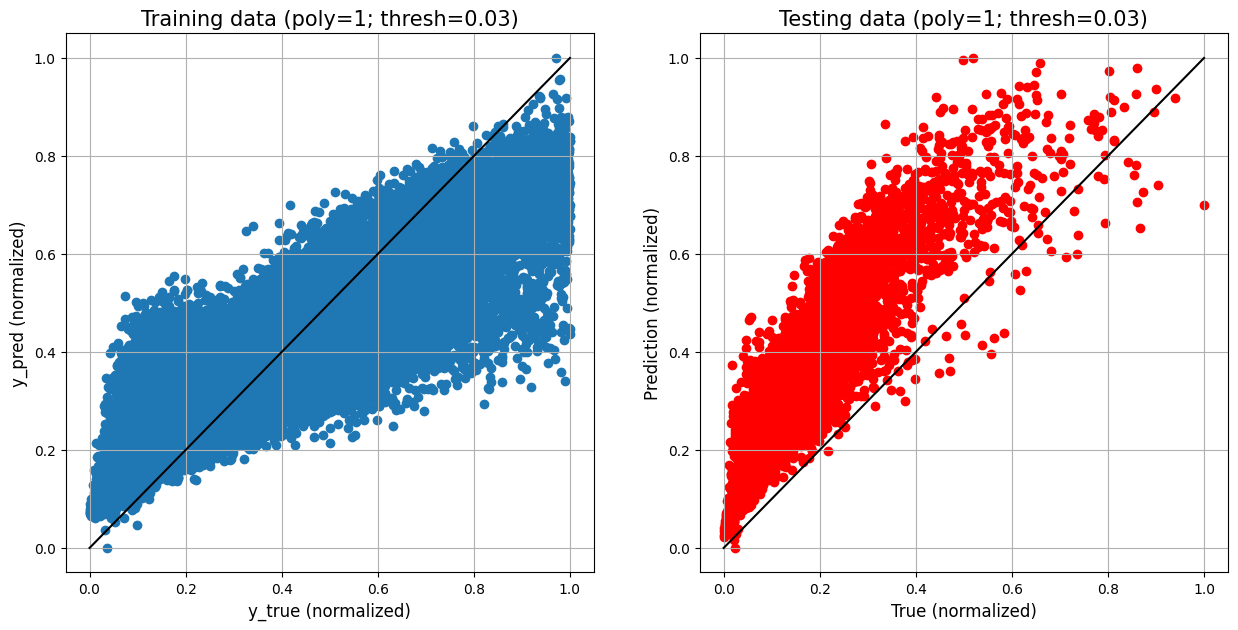


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  55074.12284506589 	scale factor:  3.0
Iteration:  1 		Error:  18600.664170042623 	scale factor:  0.3
Iteration:  2 		Error:  13150.754321377939 	scale factor:  0.3
Iteration:  3 		Error:  6693.261658001953 	scale factor:  0.03
Iteration:  4 		Error:  968.069796066475 	scale factor:  0.3
Iteration:  5 		Error:  631.270531583906 	scale factor:  3.0
Iteration:  6 		Error:  562.2165454496903 	scale factor:  3.0
Iteration:  7 		Error:  554.7345173821041 	scale factor:  3.0
Iteration:  8 		Error:  550.6871001006914 	scale factor:  3.0
Iteration:  9 		Error:  547.8465934908807 	scale factor:  3.0
Iteration:  10 		Error:  545.6412231459752 	scale factor:  3.0
Iteration:  11 		Error:  543.8301265445054 	scale factor:  3.0
Iteration:  12 		Error:  542.2764714486855 	scale factor:  3.0
Iteration:  13 		Error:  540.8996178160326 

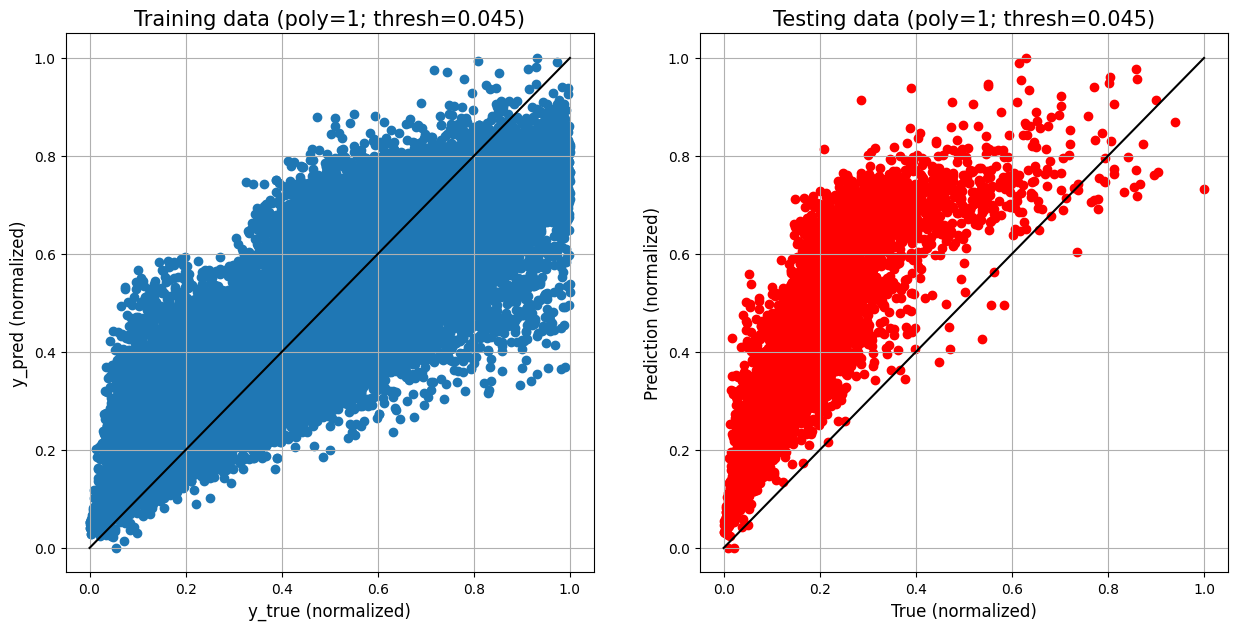


-----------------------


In [47]:
for thr in thresholds:
    
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 1, select_thresh = thr, neurons_1=32)
    print("")
    print("-----------------------")

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Iteration:  0 		Error:  28483.456571119845 	scale factor:  3.0
Iteration:  1 		Error:  3222.865858943437 	scale factor:  0.3
Iteration:  2 		Error:  2294.8493831767446 	scale factor:  0.03
Iteration:  3 		Error:  1567.3199608133498 	scale factor:  0.03
Iteration:  4 		Error:  483.71135270002554 	scale factor:  0.3
Iteration:  5 		Error:  340.51355776243054 	scale factor:  0.3
Iteration:  6 		Error:  189.72637381519087 	scale factor:  0.3
Iteration:  7 		Error:  114.23924186912572 	scale factor:  0.3
Iteration:  8 		Error:  75.18429217307926 	scale factor:  0.3
Iteration:  9 		Error:  58.304133608401955 	scale factor:  0.3
Iteration:  10 		Error:  49.7452355581286 	scale f

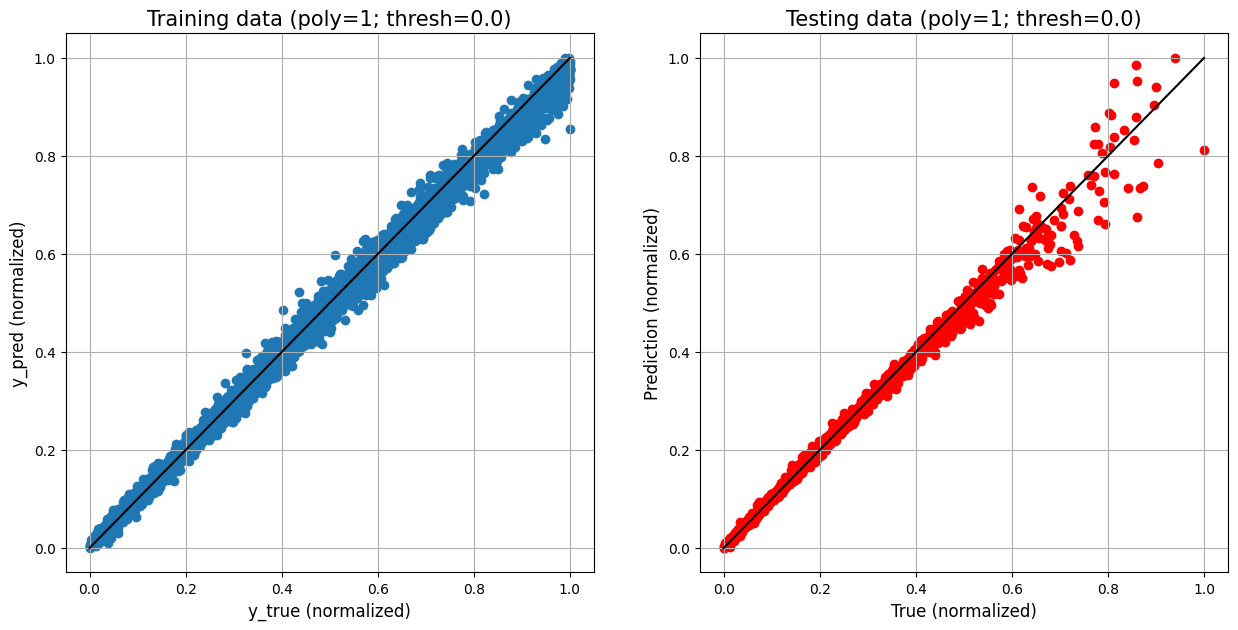


-----------------------
Relative feature selection threshold: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  10890.586490560388 	scale factor:  3.0
Iteration:  1 		Error:  3155.1957330165924 	scale factor:  0.3
Iteration:  2 		Error:  3065.730307999036 	scale factor:  0.3
Iteration:  3 		Error:  2672.472205550979 	scale factor:  0.3
Iteration:  4 		Error:  1455.0740143863325 	scale factor:  0.03
Iteration:  5 		Error:  1354.4643246529065 	scale factor:  0.03
Iteration:  6 		Error:  1098.4200712307515 	scale factor:  0.3
Iteration:  7 		Error:  446.66725706670303 	scale factor:  0.3
Iteration:  8 		Error:  243.89998522147744 	scale factor:  3.0
Iteration:  9 		Error:  150.74635410909428 	scale factor:  0.3
Iteration:  10 		Error:  98.49735991984329 	scale factor:  3.0
Iteration:  11 		Error:  69.90512583641221 	scale factor:  0.

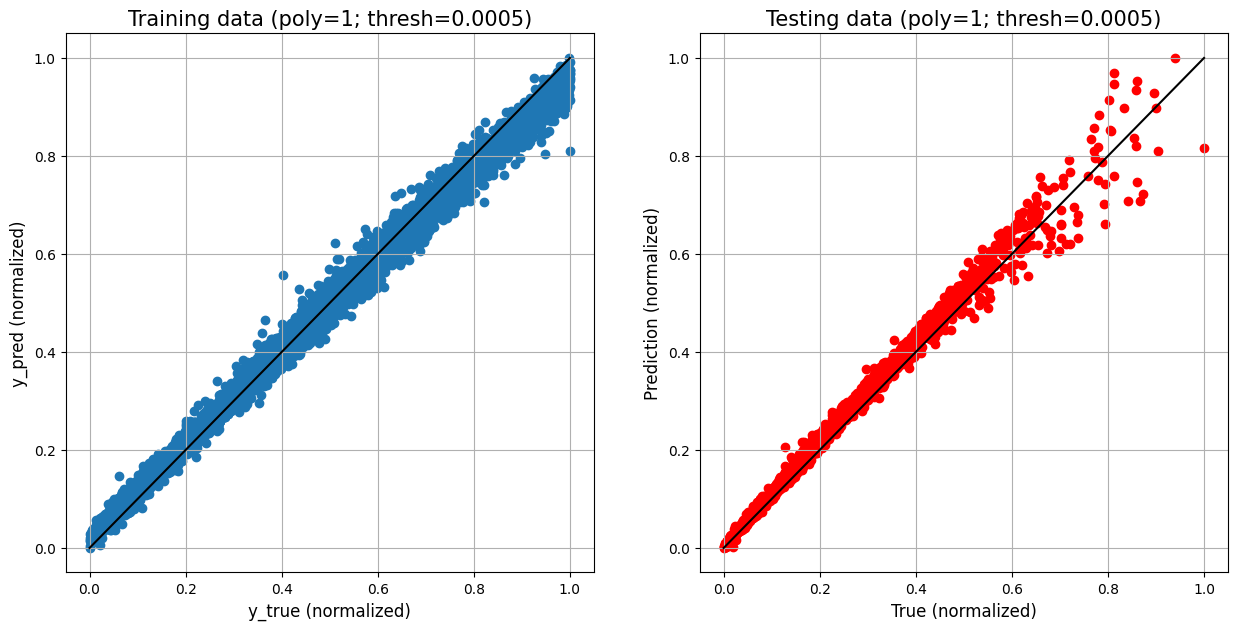


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  8612.869857412843 	scale factor:  3.0
Iteration:  1 		Error:  6413.881439544204 	scale factor:  0.3
Iteration:  2 		Error:  3454.568979895053 	scale factor:  0.03
Iteration:  3 		Error:  1810.9028548328367 	scale factor:  0.03
Iteration:  4 		Error:  1160.0680355685752 	scale factor:  3.0
Iteration:  5 		Error:  1075.5180573336193 	scale factor:  0.3
Iteration:  6 		Error:  549.1593397965357 	scale factor:  0.3
Iteration:  7 		Error:  501.2178152479744 	scale factor:  0.3
Iteration:  8 		Error:  419.18263765953054 	scale factor:  0.3
Iteration:  9 		Error:  409.2340573583226 	scale factor:  0.3
Iteration:  10 		Error:  369.9908721433756 	scale factor:  0.3
Iteration:  11 		Error:  351.4933865320482 	scale factor:  0.3
Iteration

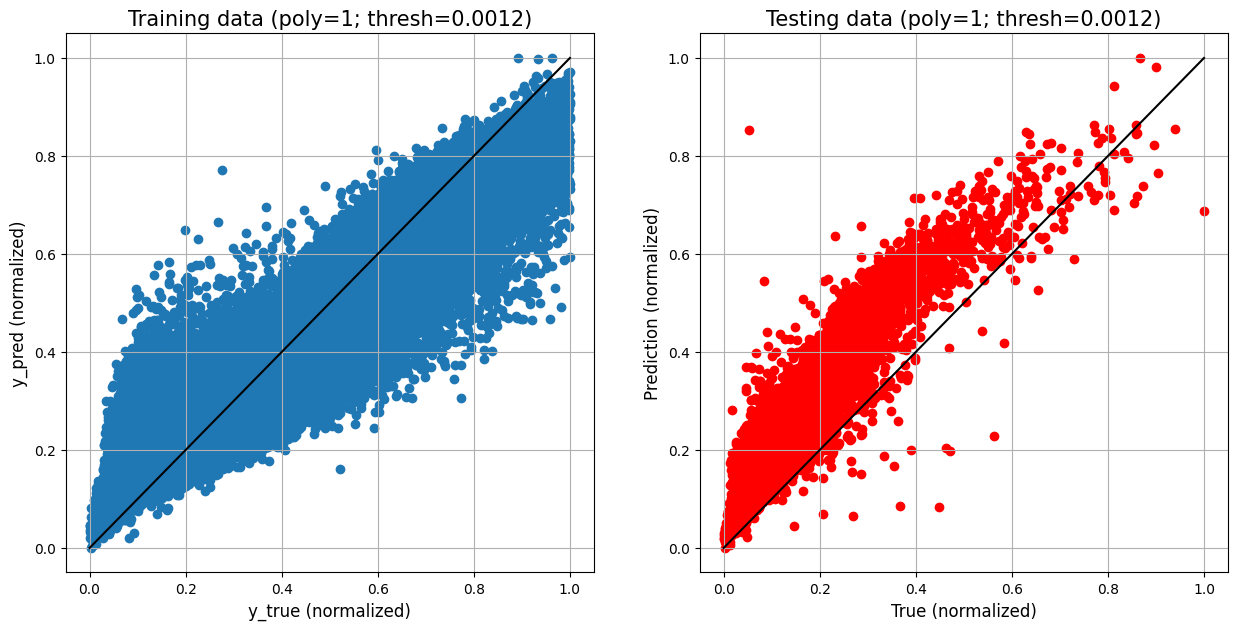


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  9089.728015518183 	scale factor:  3.0
Iteration:  1 		Error:  6359.563457617527 	scale factor:  0.3
Iteration:  2 		Error:  4963.448628794553 	scale factor:  0.3
Iteration:  3 		Error:  1671.666497539884 	scale factor:  0.3
Iteration:  4 		Error:  1601.7479010866866 	scale factor:  0.3
Iteration:  5 		Error:  506.79669702353453 	scale factor:  3.0
Iteration:  6 		Error:  410.1228129543497 	scale factor:  3.0
Iteration:  7 		Error:  406.9368466213285 	scale factor:  0.3
Iteration:  8 		Error:  357.3733266672285 	scale factor:  0.3
Iteration:  9 		Error:  348.8368056346492 	scale factor:  0.3
Iteration:  10 		Error:  331.45950252270177 	scale factor:  0.3
Iteration:  11 		Error:  325.72358968191656 	scale factor:  0.3
Iteration:  12 		Er

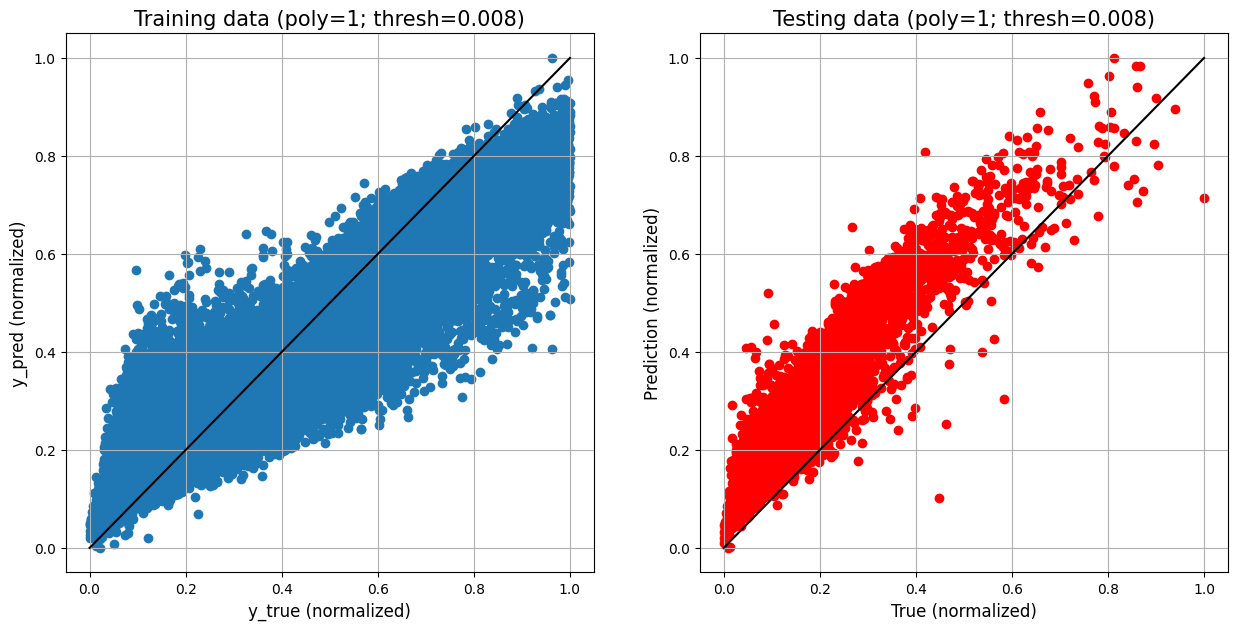


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Iteration:  0 		Error:  28704.088638802394 	scale factor:  3.0
Iteration:  1 		Error:  5957.990479299104 	scale factor:  0.3
Iteration:  2 		Error:  1453.699417742053 	scale factor:  3.0
Iteration:  3 		Error:  897.9259235320114 	scale factor:  3.0
Iteration:  4 		Error:  561.9968955209699 	scale factor:  3.0
Iteration:  5 		Error:  511.7564760783586 	scale factor:  3.0
Iteration:  6 		Error:  461.5133455475784 	scale factor:  3.0
Iteration:  7 		Error:  447.6932525207101 	scale factor:  3.0
Iteration:  8 		Error:  439.35963653471515 	scale factor:  3.0
Iteration:  9 		Error:  438.6143914163011 	scale factor:  0.3
Iteration:  10 		Error:  426.4319510630106 	scale factor:  0.3
Iteration:  11 		Error:  416.4285436743559 	scale factor:  0.3
Iteration:  12 		Error:  39

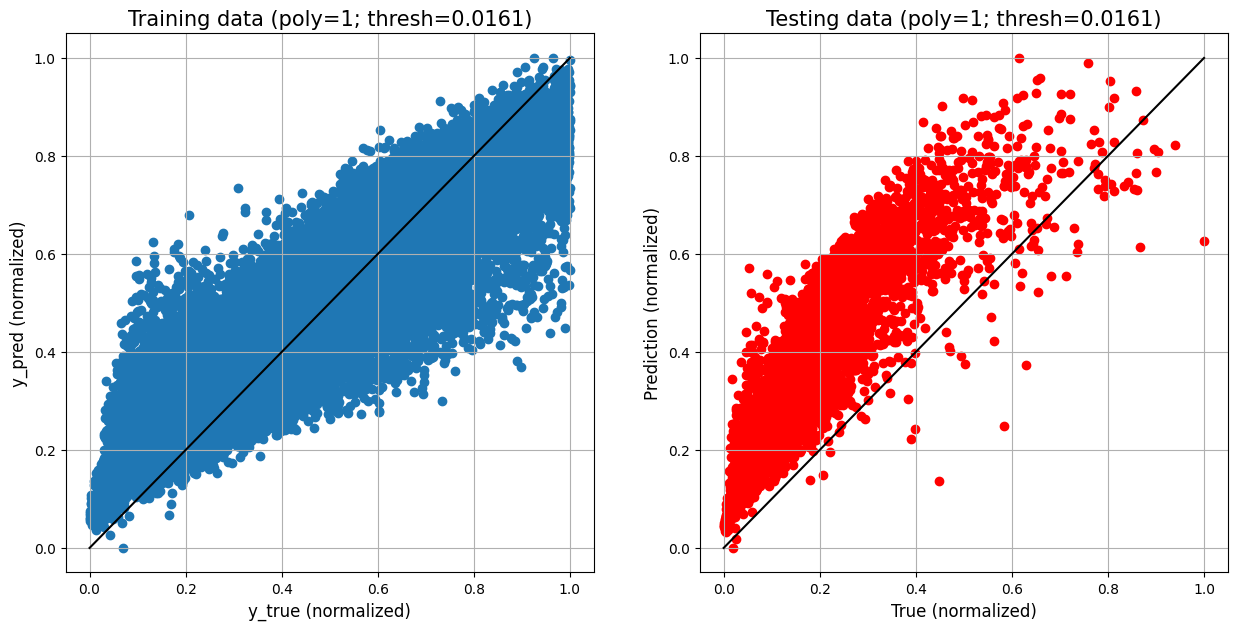


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Iteration:  0 		Error:  34271.359111013764 	scale factor:  3.0
Iteration:  1 		Error:  5238.056142957192 	scale factor:  0.3
Iteration:  2 		Error:  2299.659485125003 	scale factor:  3.0
Iteration:  3 		Error:  1053.739369201171 	scale factor:  0.3
Iteration:  4 		Error:  560.6494171397267 	scale factor:  0.3
Iteration:  5 		Error:  484.3297917775358 	scale factor:  0.3
Iteration:  6 		Error:  438.03911988361455 	scale factor:  0.3
Iteration:  7 		Error:  406.4865327955798 	scale factor:  0.3
Iteration:  8 		Error:  400.5190382460377 	scale factor:  0.3
Iteration:  9 		Error:  396.73798585755844 	scale factor:  0.3
Iteration:  10 		Error:  394.16267702676396 	scale factor:  0.3
Iteration:  11 		Error:  392.2904437005618 	scale factor:  0.3
Iteration:  12 		Error:  390.8504483967099 	scale fa

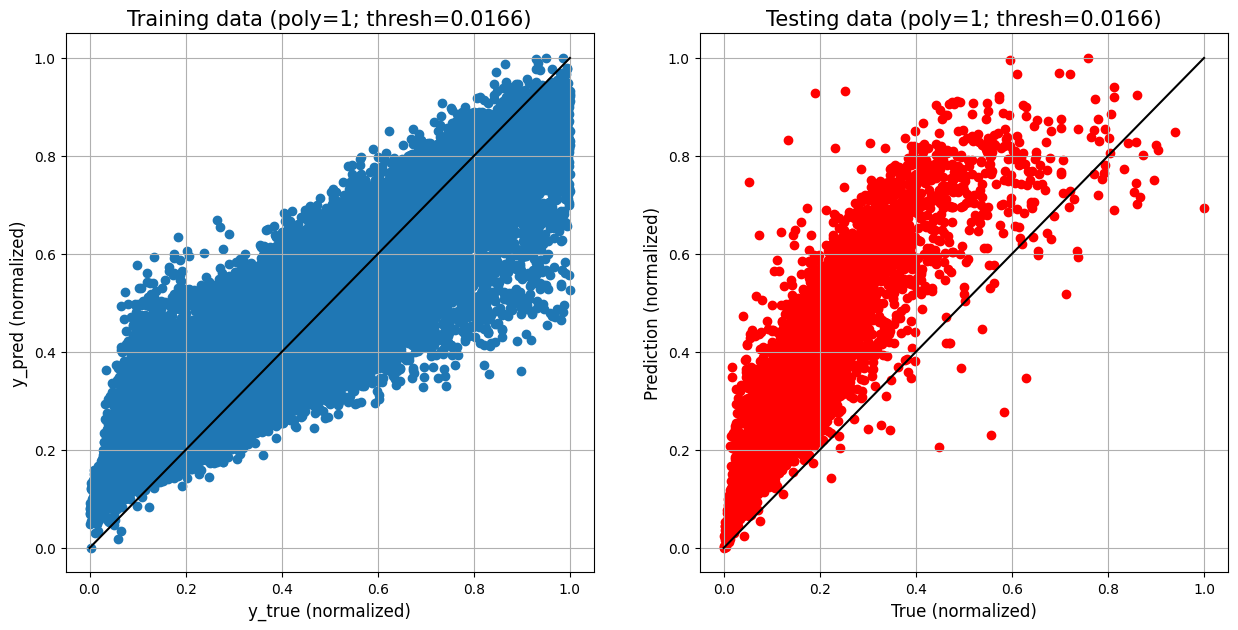


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  14823.086404355128 	scale factor:  3.0
Iteration:  1 		Error:  8088.506021574074 	scale factor:  0.3
Iteration:  2 		Error:  2620.498741982834 	scale factor:  0.3
Iteration:  3 		Error:  818.8383912235636 	scale factor:  3.0
Iteration:  4 		Error:  779.6608536527001 	scale factor:  3.0
Iteration:  5 		Error:  507.98166693504135 	scale factor:  3.0
Iteration:  6 		Error:  481.99422221132437 	scale factor:  3.0
Iteration:  7 		Error:  456.63178920537354 	scale factor:  3.0
Iteration:  8 		Error:  444.02147738552605 	scale factor:  3.0
Iteration:  9 		Error:  436.0327597544649 	scale factor:  3.0
Iteration:  10 		Error:  430.66484622085693 	scale factor:  3.0
Iteration:  11 		Error:  426.82194931286335 	scale factor:  3.0
Iteration:  12 		Error:  423.8997887641989 	scale factor:  3.0
Iteration:

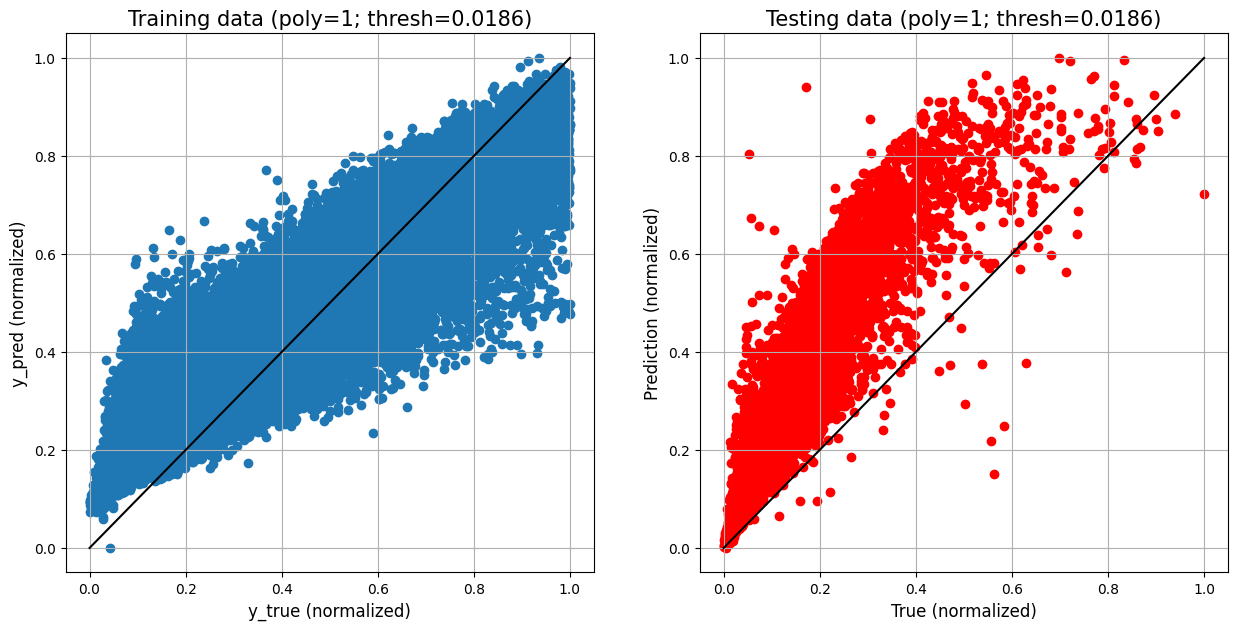


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  35382.451950864 	scale factor:  3.0
Iteration:  1 		Error:  13494.481155833946 	scale factor:  0.3
Iteration:  2 		Error:  1918.4123592755202 	scale factor:  0.3
Iteration:  3 		Error:  1494.907102122996 	scale factor:  0.3
Iteration:  4 		Error:  1161.0115861373129 	scale factor:  0.3
Iteration:  5 		Error:  885.3684752849425 	scale factor:  0.3
Iteration:  6 		Error:  686.7024970413421 	scale factor:  0.3
Iteration:  7 		Error:  559.042211777409 	scale factor:  0.3
Iteration:  8 		Error:  450.604590308993 	scale factor:  0.3
Iteration:  9 		Error:  435.88731971637844 	scale factor:  0.3
Iteration:  10 		Error:  432.7346463334308 	scale factor:  0.3
Iteration:  11 		Error:  431.4078777647656 	scale factor:  0.3
Iteration:  12 		Error:  430.0144728592215 	scale factor:  0.3
Iteration:  13 		Error:  428.6788

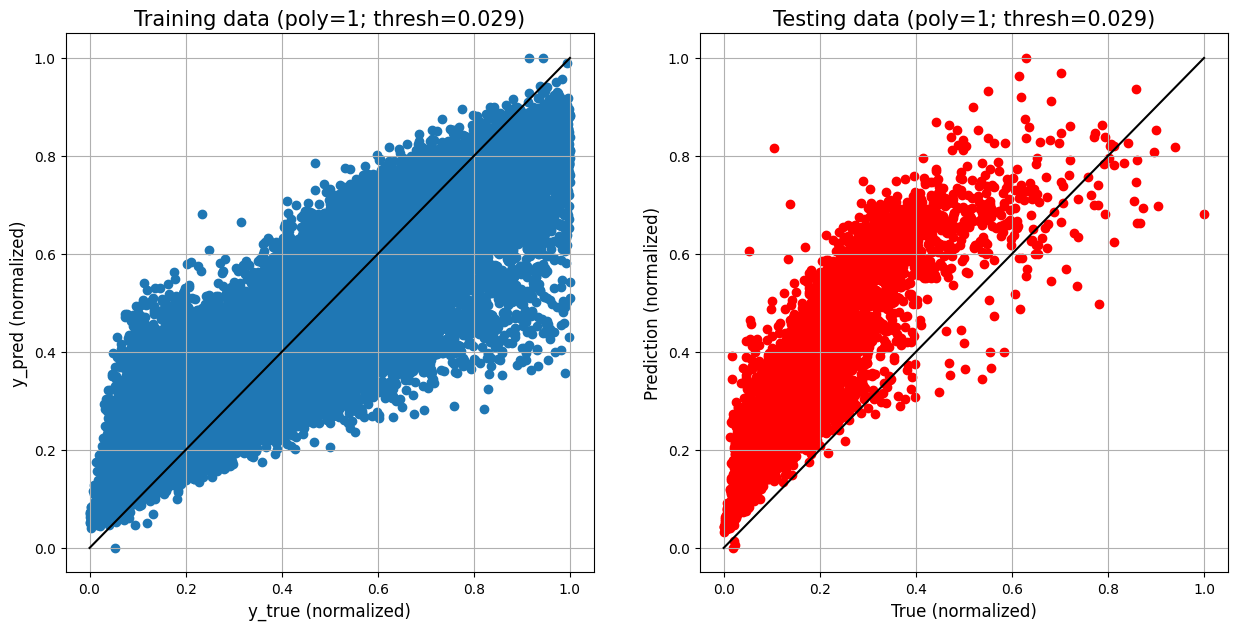


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  13757.718557970315 	scale factor:  3.0
Iteration:  1 		Error:  2520.5767813901966 	scale factor:  3.0
Iteration:  2 		Error:  964.3953536804846 	scale factor:  3.0
Iteration:  3 		Error:  563.6957335343945 	scale factor:  3.0
Iteration:  4 		Error:  525.0410672364524 	scale factor:  3.0
Iteration:  5 		Error:  484.56269517269834 	scale factor:  3.0
Iteration:  6 		Error:  472.71508701698855 	scale factor:  3.0
Iteration:  7 		Error:  466.835574357593 	scale factor:  3.0
Iteration:  8 		Error:  463.0600373038467 	scale factor:  3.0
Iteration:  9 		Error:  460.1458297345073 	scale factor:  3.0
Iteration:  10 		Error:  457.56888766176667 	scale factor:  3.0
Iteration:  11 		Error:  455.17998833713943 	scale factor:  3.0
Iteration:  12 		Error:  452.98598137001386 	scale factor:  3.0
Iteration:  13 		Error:  451.0243

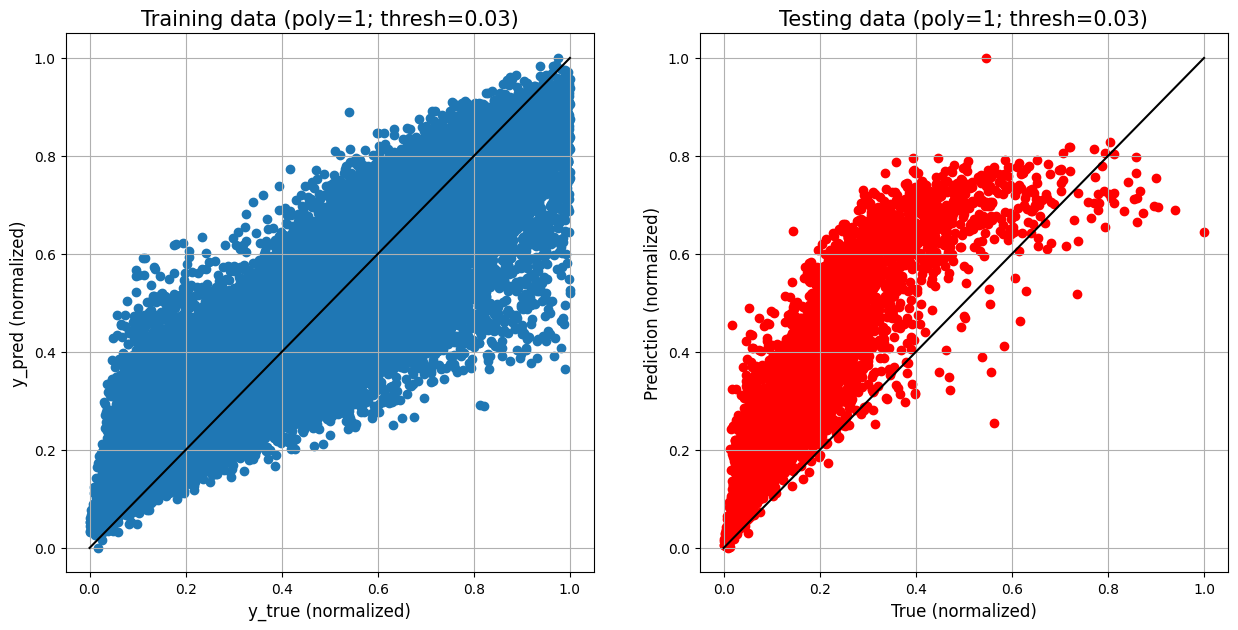


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Iteration:  0 		Error:  8652.620189529543 	scale factor:  3.0
Iteration:  1 		Error:  7001.080002034963 	scale factor:  3.0
Iteration:  2 		Error:  4747.952258222118 	scale factor:  3.0
Iteration:  3 		Error:  3807.0764250801776 	scale factor:  0.3
Iteration:  4 		Error:  898.2389790855786 	scale factor:  0.3
Iteration:  5 		Error:  850.4490394836664 	scale factor:  0.3
Iteration:  6 		Error:  575.2976614941111 	scale factor:  0.3
Iteration:  7 		Error:  515.175900263009 	scale factor:  3.0
Iteration:  8 		Error:  513.171560122063 	scale factor:  3.0
Iteration:  9 		Error:  512.018882537969 	scale factor:  3.0
Iteration:  10 		Error:  510.9762963709044 	scale factor:  3.0
Iteration:  11 		Error:  510.0040891502903 	scale factor:  3.0
Iteration:  12 		Error:  509.1024001368279 	scale factor:  3.0
Iteration:  13 		Error:  508.2763344210769 	sc

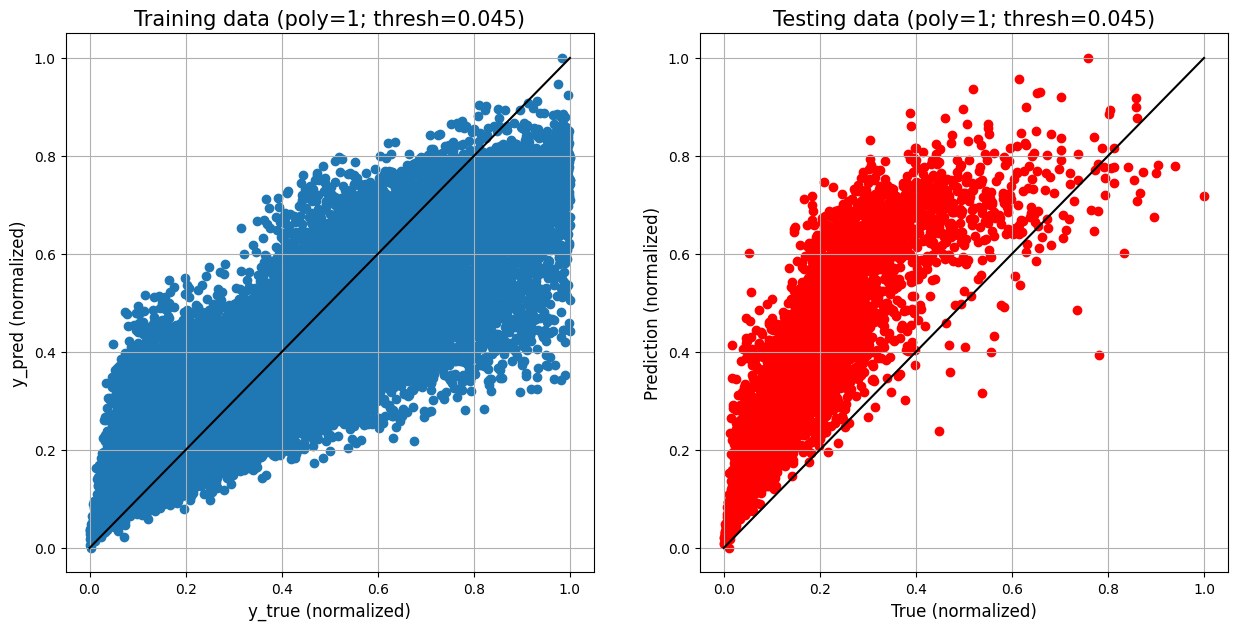


-----------------------


In [48]:
for thr in thresholds:
    
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 1, select_thresh = thr, hidden_layer_2=True, neurons_1=32, neurons_2=16)
    print("")
    print("-----------------------")